In [1]:
from glob import glob
import pandas as pd
import obspy
from obspy import read_inventory
import os
from obspy import UTCDateTime
from obspy.geodetics import gps2dist_azimuth
def distcal(stla,stlo,evla,evlo):
    return gps2dist_azimuth(stla,stlo,evla,evlo)[0]/1000
import numpy as np
from scipy.optimize import curve_fit
from obspy.taup import TauPyModel
model = TauPyModel(model="iasp91")
import matplotlib.pyplot as plt

In [2]:
def get_disp(tr):
    """Integrate acceleration to displacement.
    Args:
        tr (StationTrace):
            Trace of acceleration data. This is the trace where the Cache values will
            be set.
        config (dict):
            Configuration dictionary (or None). See get_config().
    Returns:
        StationTrace.
    """
    acc = tr.copy()
    try:
        disp = acc.integrate().integrate()
    except Exception as e:
        raise e
    return disp

def correct_baseline(trace):
    """
    Performs a baseline correction following the method of Ancheta
    et al. (2013). This removes low-frequency, non-physical trends
    that remain in the time series following filtering.
    Args:
        trace (obspy.core.trace.Trace):
            Trace of strong motion data.
        config (dict):
            Configuration dictionary (or None). See get_config().
    Returns:
        trace: Baseline-corrected trace.
    """
    # Integrate twice to get the displacement time series
    disp = get_disp(trace)

    # Fit a sixth order polynomial to displacement time series, requiring
    # that the 1st and 0th order coefficients are zero
    time_values = (
        np.linspace(0, trace.stats.npts - 1, trace.stats.npts) * trace.stats.delta
    )
    poly_cofs = list(curve_fit(_poly_func, time_values, disp.data)[0])
    poly_cofs += [0, 0]

    # Construct a polynomial from the coefficients and compute
    # the second derivative
    polynomial = np.poly1d(poly_cofs)
    polynomial_second_derivative = np.polyder(polynomial, 2)

    # Subtract the second derivative of the polynomial from the
    # acceleration trace
    trace.data -= polynomial_second_derivative(time_values)

    return trace

def _poly_func(x, a, b, c, d, e):
    """
    Model polynomial function for polynomial baseline correction.
    """
    return a * x ** 6 + b * x ** 5 + c * x ** 4 + d * x ** 3 + e * x ** 2

In [3]:
def add0(s):
    if len(str(s)) < 2:
        return "0" + str(s)
    else:
        return str(s)

def add00(s):
    if len(str(s)) == 1:
        return "00" + str(s)
    elif len(str(s)) == 2: 
        return "0" + str(s)
    else:
        return str(s)

In [4]:
def convert_utc(yy,mm,dd,hh,mi,s):
    return UTCDateTime(int(yy), int(mm), int(dd), int(hh), int(mi), int(s))
    

In [5]:
respf = "/home/nghianc/auto_pick/instrument_response/XML"
eqcat = pd.read_csv("vn_cat.csv",index_col=0)
evl = sorted([a.split("_")[-2] for a in glob("../sac_data/*")])
eqcat['utctime'] = eqcat.apply(lambda x: convert_utc(x.year, x.month, x.day, x.hour, x.minute, x.second),axis=1)


In [30]:
# record = []
for i in range(39,len(evl)):
    print("Read event {}".format(evl[i]))
    dfinfo = eqcat[eqcat['utctime'] == UTCDateTime(evl[i])].reset_index(drop=True)
    sacl = glob("../sac_data/*{}*/*".format(evl[i]))
    stal = list(set([a.split("/")[-1].split(".")[0] for a in sacl]))
    fs,nf = [],[]
    for sta in stal:
        try:
            inv = read_inventory(os.path.join(respf,"VN.{}.xml".format(sta)))
    #         print("Found station {}".format(sta))
            fs.append(sta)
        except:
            print("Station {} not found".format(sta))
            nf.append(sta)
            pass
    sacpr = [a for a in [a for a in sacl if a.split("/")[-1].split(".")[0] in fs] if "HHN" in a]
    sacpr = [a.replace("HHN","HH*") for a in sacpr]
    # for sacfile in sacpr:
    for file in sacpr:
        sta = file.split("/")[-1].split(".")[0]
        inv = read_inventory(os.path.join(respf,"VN.{}.xml".format(sta)))
        for chan in inv[0][0]:
            chan.start_date = UTCDateTime(2000,1,1)
            chan.end_date = UTCDateTime(2025,1,1)
        try:
            ev = evl[i]
            st = obspy.read(file)
            sr = 100
            trz = st.select(component="Z")[0].interpolate(sampling_rate=sr)
            tre = st.select(component="E")[0].interpolate(sampling_rate=sr)
            trn = st.select(component="N")[0].interpolate(sampling_rate=sr)
            pre_filt = (0.005, 0.006, 30.0, 35.0)
            for tr in [trz,tre,trn]:
                tr.detrend("demean")
                tr = correct_baseline(tr)
                tr.stats.channel = tr.stats.channel.replace("HH ","HH")
                tr.remove_response(inventory=inv, pre_filt=pre_filt, output="ACC",
                       water_level=60)

            df = trz.stats.sampling_rate



            stla = "{:.3f}".format(inv[0][0].latitude)
            stlo = "{:.3f}".format(inv[0][0].longitude)
            evla = "{:.3f}".format(dfinfo.Lat[0])
            evlo = "{:.3f}".format(dfinfo.Lon[0])
            evdp = "{:.3f}".format(dfinfo.Depth[0])
            mag = "{:.1f}".format(dfinfo.Ml[0])
            dis = distcal(float(stla),float(stlo),float(evla),float(evlo))
            t0 = UTCDateTime(evl[i])
            ml = mag
        #     mw = 

#             arrivals = model.get_travel_times(source_depth_in_km=evdp,
#                                       distance_in_degree=dis,
#                                       phase_list=["P"])
            print(ev,UTCDateTime(t0))
            print("Read station {} - event {} - distance {}".format(sta,ev,dis))
            trn=trn.trim(t0,t0+180)
            trz=trz.trim(t0,t0+180)
            tre=tre.trim(t0,t0+180)
    #         trn.plot()
    #         trz.plot()
    #         tre.plot()
            if trn.data.mean() == 0 or tre.data.mean() == 0 or trz.data.mean() == 0:
                print("Missing component!")
                nfile = "ascii/{}_{}_mc_{}hz.cwb".format(sta,ev,sr)
            else:
                nfile = "ascii/{}_{}_{}hz.cwb".format(sta,ev,sr)
            print(nfile)
            if dis < 300:
                with open(nfile,"w") as f:
                    print("%StationCode:",sta,file=f)
                    print("%StationLat:",stla,file=f)
                    print("%StationLon:",stlo,file=f)
                    print("%EventLat:",evla,file=f)
                    print("%EventLon:",evlo,file=f)
                    print("%EventML: {}".format(ml),file=f)
            #         print("%EventMW: {:.2f}".format(mw),file=f)
                    print("%EventDep: {}".format(evdp),file=f)
                    print("%InstrumentKind: N.A.",file=f)
                    print("%StartTime:",t0,file=f)
                    print("%SampleRate(Hz): 100",file=f)
                    print("%AmplitudeUnit: cm/ss",file=f)
                    print("%AmplitudeMAX. U: {:.4f}~ {:.4f}".format(max(trz.data)*100,min(trz.data)*100),file=f)
                    print("%AmplitudeMAX. N: {:.4f}~ {:.4f}".format(max(trn.data)*100,min(trn.data)*100),file=f)
                    print("%AmplitudeMAX. E: {:.4f}~ {:.4f}".format(max(tre.data)*100,min(tre.data)*100),file=f)
                    print("%DataSequence: Time U(+); N(+), E(+)",file=f)
                    print("%Data: 4F10.3",file=f)
                    for k in range(0,len(trz.data)):
                        t = 0 + 1/sr*k
                        print("{:11.3f}{:10.4f}{:10.4f}{:10.4f}".format(t,trz.data[k]*100,trn.data[k]*100,tre.data[k]*100),file=f)
#                     rec = {"eqid":ev,"evla":evla,"evlo":evlo,"evdp":evdp,"sta":sta,"stla":stla,"stlo":stlo,"dis":dis}
#                     record.append(rec)
        except IndexError:
    #         raise
            print("!!!File {} has error!!!".format(file))
# record = pd.DataFrame(record)
# record.to_csv("recordVN.csv")

Read event 20131021151005
Station AGVB not found
Station NTVB not found
Station BVVB not found
Station BDVB not found
20131021151005 2013-10-21T15:10:05.000000Z
Read station VR12 - event 20131021151005 - distance 216.8628474806684
ascii/VR12_20131021151005_100hz.cwb
20131021151005 2013-10-21T15:10:05.000000Z
Read station VR02 - event 20131021151005 - distance 308.19073168125
ascii/VR02_20131021151005_100hz.cwb
20131021151005 2013-10-21T15:10:05.000000Z
Read station VR13 - event 20131021151005 - distance 208.94864146405206
ascii/VR13_20131021151005_100hz.cwb
20131021151005 2013-10-21T15:10:05.000000Z
Read station VR23 - event 20131021151005 - distance 132.37316386963897
ascii/VR23_20131021151005_100hz.cwb
20131021151005 2013-10-21T15:10:05.000000Z
Read station VR06 - event 20131021151005 - distance 270.73057909645973
ascii/VR06_20131021151005_100hz.cwb
20131021151005 2013-10-21T15:10:05.000000Z
Read station HUVB - event 20131021151005 - distance 636.9214936288006
ascii/HUVB_201310211510

20140128120157 2014-01-28T12:01:57.000000Z
Read station VR23 - event 20140128120157 - distance 455.3502386814615
ascii/VR23_20140128120157_100hz.cwb
20140128120157 2014-01-28T12:01:57.000000Z
Read station VIVB - event 20140128120157 - distance 807.7746485905528
ascii/VIVB_20140128120157_100hz.cwb
Read event 20140128120221
Station AGVB not found
Station NTVB not found
Station BVVB not found
Station BDVB not found
20140128120221 2014-01-28T12:02:21.000000Z
Read station VR19 - event 20140128120221 - distance 276.54135230937544
ascii/VR19_20140128120221_100hz.cwb
20140128120221 2014-01-28T12:02:21.000000Z
Read station VR21 - event 20140128120221 - distance 269.2250606517867
ascii/VR21_20140128120221_100hz.cwb
20140128120221 2014-01-28T12:02:21.000000Z
Read station VR25 - event 20140128120221 - distance 254.25760684471086
ascii/VR25_20140128120221_100hz.cwb
20140128120221 2014-01-28T12:02:21.000000Z
Read station VR02 - event 20140128120221 - distance 396.0482202081384
ascii/VR02_20140128120

20140501180850 2014-05-01T18:08:50.000000Z
Read station VR04 - event 20140501180850 - distance 568.5573945336595
ascii/VR04_20140501180850_100hz.cwb
20140501180850 2014-05-01T18:08:50.000000Z
Read station VR10 - event 20140501180850 - distance 520.9104536532345
ascii/VR10_20140501180850_100hz.cwb
20140501180850 2014-05-01T18:08:50.000000Z
Read station VR18 - event 20140501180850 - distance 466.46084401370973
ascii/VR18_20140501180850_100hz.cwb
20140501180850 2014-05-01T18:08:50.000000Z
Read station VR15 - event 20140501180850 - distance 485.31592118704464
ascii/VR15_20140501180850_100hz.cwb
20140501180850 2014-05-01T18:08:50.000000Z
Read station VR05 - event 20140501180850 - distance 558.6137485112682
ascii/VR05_20140501180850_100hz.cwb
20140501180850 2014-05-01T18:08:50.000000Z
Read station HBVB - event 20140501180850 - distance 452.02103044025455
ascii/HBVB_20140501180850_100hz.cwb
Read event 20140626124410
Station AGVB not found
Station NTVB not found
Station BVVB not found
Station 

20140629045112 2014-06-29T04:51:12.000000Z
Read station VR01 - event 20140629045112 - distance 468.18887933913504
ascii/VR01_20140629045112_100hz.cwb
20140629045112 2014-06-29T04:51:12.000000Z
Read station VR03 - event 20140629045112 - distance 456.50323317470196
ascii/VR03_20140629045112_100hz.cwb
20140629045112 2014-06-29T04:51:12.000000Z
Read station VR04 - event 20140629045112 - distance 451.96187852732044
ascii/VR04_20140629045112_100hz.cwb
20140629045112 2014-06-29T04:51:12.000000Z
Read station VR06 - event 20140629045112 - distance 438.12615488770507
ascii/VR06_20140629045112_100hz.cwb
Read event 20140719121457
Station AGVB not found
Station NTVB not found
Station BVVB not found
Station BDVB not found
20140719121457 2014-07-19T12:14:57.000000Z
Read station TGVB - event 20140719121457 - distance 58.722131067023895
ascii/TGVB_20140719121457_100hz.cwb
20140719121457 2014-07-19T12:14:57.000000Z
Read station VR09 - event 20140719121457 - distance 224.96553761548466
ascii/VR09_2014071

20140819235017 2014-08-19T23:50:17.000000Z
Read station VR23 - event 20140819235017 - distance 156.8072781902751
ascii/VR23_20140819235017_100hz.cwb
20140819235017 2014-08-19T23:50:17.000000Z
Read station VIVB - event 20140819235017 - distance 580.264077256617
ascii/VIVB_20140819235017_100hz.cwb
20140819235017 2014-08-19T23:50:17.000000Z
Read station HBVB - event 20140819235017 - distance 163.6146439748305
ascii/HBVB_20140819235017_100hz.cwb
Read event 20140827104513
Station AGVB not found
Station NTVB not found
Station BVVB not found
Station BDVB not found
20140827104513 2014-08-27T10:45:13.000000Z
Read station VR23 - event 20140827104513 - distance 494.5571262695522
ascii/VR23_20140827104513_100hz.cwb
20140827104513 2014-08-27T10:45:13.000000Z
Read station VR17 - event 20140827104513 - distance 516.499968182016
ascii/VR17_20140827104513_100hz.cwb
20140827104513 2014-08-27T10:45:13.000000Z
Read station VR11 - event 20140827104513 - distance 542.8459504745443
ascii/VR11_20140827104513_

20150220223747 2015-02-20T22:37:47.000000Z
Read station VR24 - event 20150220223747 - distance 439.84713801760756
ascii/VR24_20150220223747_100hz.cwb
20150220223747 2015-02-20T22:37:47.000000Z
Read station VR23 - event 20150220223747 - distance 440.3251460674534
ascii/VR23_20150220223747_100hz.cwb
20150220223747 2015-02-20T22:37:47.000000Z
Read station VR04 - event 20150220223747 - distance 516.2660045643181
ascii/VR04_20150220223747_100hz.cwb
20150220223747 2015-02-20T22:37:47.000000Z
Read station HUVB - event 20150220223747 - distance 961.2616150696646
ascii/HUVB_20150220223747_100hz.cwb
20150220223747 2015-02-20T22:37:47.000000Z
Read station VR03 - event 20150220223747 - distance 520.084559830826
ascii/VR03_20150220223747_100hz.cwb
Read event 20150612083911
Station AGVB not found
Station NTVB not found
Station BVVB not found
Station BDVB not found
20150612083911 2015-06-12T08:39:11.000000Z
Read station VR24 - event 20150612083911 - distance 158.65191324541493
ascii/VR24_201506120839

20150629011227 2015-06-29T01:12:27.000000Z
Read station VR02 - event 20150629011227 - distance 480.28715268094606
ascii/VR02_20150629011227_100hz.cwb
20150629011227 2015-06-29T01:12:27.000000Z
Read station VR10 - event 20150629011227 - distance 405.34239895957984
ascii/VR10_20150629011227_100hz.cwb
20150629011227 2015-06-29T01:12:27.000000Z
Read station VR23 - event 20150629011227 - distance 287.85010203578406
ascii/VR23_20150629011227_100hz.cwb
Read event 20150701200034
Station AGVB not found
Station NTVB not found
Station BVVB not found
Station BDVB not found
20150701200034 2015-07-01T20:00:34.000000Z
Read station VR24 - event 20150701200034 - distance 297.1567367152734
ascii/VR24_20150701200034_100hz.cwb
20150701200034 2015-07-01T20:00:34.000000Z
Read station VIVB - event 20150701200034 - distance 729.1517596768517
ascii/VIVB_20150701200034_100hz.cwb
20150701200034 2015-07-01T20:00:34.000000Z
Read station VR06 - event 20150701200034 - distance 319.34528730502564
ascii/VR06_201507012

20150703103146 2015-07-03T10:31:46.000000Z
Read station VR17 - event 20150703103146 - distance 307.98504111384636
ascii/VR17_20150703103146_100hz.cwb
20150703103146 2015-07-03T10:31:46.000000Z
Read station VIVB - event 20150703103146 - distance 741.5340665765602
ascii/VIVB_20150703103146_100hz.cwb
20150703103146 2015-07-03T10:31:46.000000Z
Read station PLVB - event 20150703103146 - distance 406.1929744157532
ascii/PLVB_20150703103146_100hz.cwb
Read event 20150814021459
Station AGVB not found
Station NTVB not found
Station BC2 not found
Station BVVB not found
Station BDVB not found
20150814021459 2015-08-14T02:14:59.000000Z
Read station VR01 - event 20150814021459 - distance 433.02172004877707
ascii/VR01_20150814021459_100hz.cwb
20150814021459 2015-08-14T02:14:59.000000Z
Read station VR03 - event 20150814021459 - distance 413.7995904637715
ascii/VR03_20150814021459_100hz.cwb
20150814021459 2015-08-14T02:14:59.000000Z
Read station VR25 - event 20150814021459 - distance 196.11762163104206

20150914204354 2015-09-14T20:43:54.000000Z
Read station MLAV - event 20150914204354 - distance 116.0154690357441
ascii/MLAV_20150914204354_100hz.cwb
20150914204354 2015-09-14T20:43:54.000000Z
Read station VR06 - event 20150914204354 - distance 332.5367166488805
ascii/VR06_20150914204354_100hz.cwb
20150914204354 2015-09-14T20:43:54.000000Z
Read station VR09 - event 20150914204354 - distance 322.32463875804626
ascii/VR09_20150914204354_100hz.cwb
20150914204354 2015-09-14T20:43:54.000000Z
Read station TGVB - event 20150914204354 - distance 159.82430346530919
ascii/TGVB_20150914204354_100hz.cwb
20150914204354 2015-09-14T20:43:54.000000Z
Read station VR14 - event 20150914204354 - distance 310.87068454149454
ascii/VR14_20150914204354_100hz.cwb
20150914204354 2015-09-14T20:43:54.000000Z
Read station VR15 - event 20150914204354 - distance 309.4709018278397
ascii/VR15_20150914204354_100hz.cwb
20150914204354 2015-09-14T20:43:54.000000Z
Read station VR23 - event 20150914204354 - distance 308.6015

20151102184331 2015-11-02T18:43:31.000000Z
Read station VR19 - event 20151102184331 - distance 410.64150194956375
ascii/VR19_20151102184331_100hz.cwb
20151102184331 2015-11-02T18:43:31.000000Z
Read station VR10 - event 20151102184331 - distance 446.59863183293555
ascii/VR10_20151102184331_100hz.cwb
20151102184331 2015-11-02T18:43:31.000000Z
Read station VR22 - event 20151102184331 - distance 406.211834010134
ascii/VR22_20151102184331_100hz.cwb
20151102184331 2015-11-02T18:43:31.000000Z
Read station VR01 - event 20151102184331 - distance 494.8336120763515
ascii/VR01_20151102184331_100hz.cwb
20151102184331 2015-11-02T18:43:31.000000Z
Read station VR15 - event 20151102184331 - distance 425.9908822432886
ascii/VR15_20151102184331_100hz.cwb
20151102184331 2015-11-02T18:43:31.000000Z
Read station VR08 - event 20151102184331 - distance 456.26988859666454
ascii/VR08_20151102184331_100hz.cwb
20151102184331 2015-11-02T18:43:31.000000Z
Read station VR17 - event 20151102184331 - distance 418.52239

20160121134815 2016-01-21T13:48:15.000000Z
Read station VR21 - event 20160121134815 - distance 266.8604532419812
ascii/VR21_20160121134815_100hz.cwb
20160121134815 2016-01-21T13:48:15.000000Z
Read station VR06 - event 20160121134815 - distance 381.6448940484525
ascii/VR06_20160121134815_100hz.cwb
20160121134815 2016-01-21T13:48:15.000000Z
Read station VR12 - event 20160121134815 - distance 331.73692315902844
ascii/VR12_20160121134815_100hz.cwb
20160121134815 2016-01-21T13:48:15.000000Z
Read station VR16 - event 20160121134815 - distance 301.39408427045225
ascii/VR16_20160121134815_100hz.cwb
20160121134815 2016-01-21T13:48:15.000000Z
Read station VR09 - event 20160121134815 - distance 356.9554993319443
ascii/VR09_20160121134815_100hz.cwb
20160121134815 2016-01-21T13:48:15.000000Z
Read station VR17 - event 20160121134815 - distance 294.10607258533435
ascii/VR17_20160121134815_100hz.cwb
20160121134815 2016-01-21T13:48:15.000000Z
Read station TGVB - event 20160121134815 - distance 86.65504

20160307012439 2016-03-07T01:24:39.000000Z
Read station VR11 - event 20160307012439 - distance 437.1077448336523
ascii/VR11_20160307012439_100hz.cwb
20160307012439 2016-03-07T01:24:39.000000Z
Read station VR16 - event 20160307012439 - distance 414.0109477875813
ascii/VR16_20160307012439_100hz.cwb
20160307012439 2016-03-07T01:24:39.000000Z
Read station HBVB - event 20160307012439 - distance 397.6677864771452
ascii/HBVB_20160307012439_100hz.cwb
20160307012439 2016-03-07T01:24:39.000000Z
Read station VR10 - event 20160307012439 - distance 442.4642803057652
ascii/VR10_20160307012439_100hz.cwb
20160307012439 2016-03-07T01:24:39.000000Z
Read station VR02 - event 20160307012439 - distance 489.72072086545967
ascii/VR02_20160307012439_100hz.cwb
20160307012439 2016-03-07T01:24:39.000000Z
Read station VR12 - event 20160307012439 - distance 431.61475729714283
ascii/VR12_20160307012439_100hz.cwb
20160307012439 2016-03-07T01:24:39.000000Z
Read station VR09 - event 20160307012439 - distance 448.46484

20160504075736 2016-05-04T07:57:36.000000Z
Read station VR16 - event 20160504075736 - distance 379.0803389081497
ascii/VR16_20160504075736_100hz.cwb
20160504075736 2016-05-04T07:57:36.000000Z
Read station VR17 - event 20160504075736 - distance 377.5654443344064
ascii/VR17_20160504075736_100hz.cwb
20160504075736 2016-05-04T07:57:36.000000Z
Read station VR03 - event 20160504075736 - distance 413.17618262609915
ascii/VR03_20160504075736_100hz.cwb
20160504075736 2016-05-04T07:57:36.000000Z
Read station VR12 - event 20160504075736 - distance 384.09344236193033
ascii/VR12_20160504075736_100hz.cwb
20160504075736 2016-05-04T07:57:36.000000Z
Read station VR21 - event 20160504075736 - distance 378.18762185323914
ascii/VR21_20160504075736_100hz.cwb
20160504075736 2016-05-04T07:57:36.000000Z
Read station VR02 - event 20160504075736 - distance 416.48171917483364
ascii/VR02_20160504075736_100hz.cwb
20160504075736 2016-05-04T07:57:36.000000Z
Read station HUVB - event 20160504075736 - distance 913.799

20160504221744 2016-05-04T22:17:44.000000Z
Read station HBVB - event 20160504221744 - distance 351.98920900910326
ascii/HBVB_20160504221744_100hz.cwb
20160504221744 2016-05-04T22:17:44.000000Z
Read station TGVB - event 20160504221744 - distance 196.38865237608346
ascii/TGVB_20160504221744_100hz.cwb
20160504221744 2016-05-04T22:17:44.000000Z
Read station VR22 - event 20160504221744 - distance 356.3008968004061
ascii/VR22_20160504221744_100hz.cwb
20160504221744 2016-05-04T22:17:44.000000Z
Read station VR15 - event 20160504221744 - distance 355.1213282679486
ascii/VR15_20160504221744_100hz.cwb
20160504221744 2016-05-04T22:17:44.000000Z
Read station VR21 - event 20160504221744 - distance 354.94434818615366
ascii/VR21_20160504221744_100hz.cwb
20160504221744 2016-05-04T22:17:44.000000Z
Read station VR17 - event 20160504221744 - distance 352.946756858279
ascii/VR17_20160504221744_100hz.cwb
20160504221744 2016-05-04T22:17:44.000000Z
Read station VR05 - event 20160504221744 - distance 378.71237

20160807095955 2016-08-07T09:59:55.000000Z
Read station VR05 - event 20160807095955 - distance 439.49789747877395
ascii/VR05_20160807095955_100hz.cwb
20160807095955 2016-08-07T09:59:55.000000Z
Read station TGVB - event 20160807095955 - distance 146.02261998349286
ascii/TGVB_20160807095955_100hz.cwb
Read event 20160922133414
Station NTVB not found
Station BC2 not found
Station BVVB not found
Station BDVB not found
20160922133414 2016-09-22T13:34:14.000000Z
Read station VR05 - event 20160922133414 - distance 538.6127420534789
ascii/VR05_20160922133414_100hz.cwb
20160922133414 2016-09-22T13:34:14.000000Z
Read station VR03 - event 20160922133414 - distance 549.302944066194
ascii/VR03_20160922133414_100hz.cwb
20160922133414 2016-09-22T13:34:14.000000Z
Read station PLVB - event 20160922133414 - distance 595.606272446269
ascii/PLVB_20160922133414_100hz.cwb
20160922133414 2016-09-22T13:34:14.000000Z
Read station VR12 - event 20160922133414 - distance 505.3082396627093
ascii/VR12_20160922133414

Station AGVB not found
Station BC2 not found
Station BVVB not found
Station BDVB not found
20161014222417 2016-10-14T22:24:17.000000Z
Read station VR22 - event 20161014222417 - distance 431.79372657281436
ascii/VR22_20161014222417_100hz.cwb
20161014222417 2016-10-14T22:24:17.000000Z
Read station VR14 - event 20161014222417 - distance 465.4120433012133
ascii/VR14_20161014222417_100hz.cwb
20161014222417 2016-10-14T22:24:17.000000Z
Read station VR15 - event 20161014222417 - distance 460.4852446949649
ascii/VR15_20161014222417_100hz.cwb
20161014222417 2016-10-14T22:24:17.000000Z
Read station VIVB - event 20161014222417 - distance 789.4560553283262
ascii/VIVB_20161014222417_100hz.cwb
20161014222417 2016-10-14T22:24:17.000000Z
Read station VR01 - event 20161014222417 - distance 541.8389509177169
ascii/VR01_20161014222417_100hz.cwb
20161014222417 2016-10-14T22:24:17.000000Z
Read station VR13 - event 20161014222417 - distance 470.93926679604056
ascii/VR13_20161014222417_100hz.cwb
2016101422241

20161027101247 2016-10-27T10:12:47.000000Z
Read station VIVB - event 20161027101247 - distance 426.9367365673529
ascii/VIVB_20161027101247_100hz.cwb
20161027101247 2016-10-27T10:12:47.000000Z
Read station VR10 - event 20161027101247 - distance 200.65908518557143
ascii/VR10_20161027101247_100hz.cwb
20161027101247 2016-10-27T10:12:47.000000Z
Read station VR06 - event 20161027101247 - distance 239.71300569061498
ascii/VR06_20161027101247_100hz.cwb
Read event 20161130141220
Station BC2 not found
Station BVVB not found
20161130141220 2016-11-30T14:12:20.000000Z
Read station VR08 - event 20161130141220 - distance 474.4978117909057
ascii/VR08_20161130141220_100hz.cwb
20161130141220 2016-11-30T14:12:20.000000Z
Read station VR11 - event 20161130141220 - distance 460.1666042567308
ascii/VR11_20161130141220_100hz.cwb
20161130141220 2016-11-30T14:12:20.000000Z
Read station VR01 - event 20161130141220 - distance 512.7500030839738
ascii/VR01_20161130141220_100hz.cwb
20161130141220 2016-11-30T14:12:2

20161208164344 2016-12-08T16:43:44.000000Z
Read station VR14 - event 20161208164344 - distance 421.88154971668354
ascii/VR14_20161208164344_100hz.cwb
20161208164344 2016-12-08T16:43:44.000000Z
Read station HBVB - event 20161208164344 - distance 395.75697096707637
ascii/HBVB_20161208164344_100hz.cwb
20161208164344 2016-12-08T16:43:44.000000Z
Read station TGVB - event 20161208164344 - distance 183.68813206161897
ascii/TGVB_20161208164344_100hz.cwb
20161208164344 2016-12-08T16:43:44.000000Z
Read station VR06 - event 20161208164344 - distance 465.4281274231568
ascii/VR06_20161208164344_100hz.cwb
Read event 20170421144135
Station NTVB not found
Station BC2 not found
Station BVVB not found
20170421144135 2017-04-21T14:41:35.000000Z
Read station VR19 - event 20170421144135 - distance 34.56517702816755
ascii/VR19_20170421144135_100hz.cwb
20170421144135 2017-04-21T14:41:35.000000Z
Read station HBVB - event 20170421144135 - distance 26.766059354951736
ascii/HBVB_20170421144135_100hz.cwb
20170421

20170815051606 2017-08-15T05:16:06.000000Z
Read station VR02 - event 20170815051606 - distance 148.21890492949294
ascii/VR02_20170815051606_100hz.cwb
20170815051606 2017-08-15T05:16:06.000000Z
Read station VR18 - event 20170815051606 - distance 248.5440567991619
ascii/VR18_20170815051606_100hz.cwb
20170815051606 2017-08-15T05:16:06.000000Z
Read station VR10 - event 20170815051606 - distance 189.1102410567501
ascii/VR10_20170815051606_100hz.cwb
20170815051606 2017-08-15T05:16:06.000000Z
Read station MLAV - event 20170815051606 - distance 330.90041483139214
ascii/MLAV_20170815051606_100hz.cwb
20170815051606 2017-08-15T05:16:06.000000Z
Read station VR16 - event 20170815051606 - distance 234.51250813787416
ascii/VR16_20170815051606_100hz.cwb
20170815051606 2017-08-15T05:16:06.000000Z
Read station VR05 - event 20170815051606 - distance 162.10352604486076
ascii/VR05_20170815051606_100hz.cwb
20170815051606 2017-08-15T05:16:06.000000Z
Read station VR04 - event 20170815051606 - distance 157.550

20171008171034 2017-10-08T17:10:34.000000Z
Read station VR16 - event 20171008171034 - distance 241.48972514950015
ascii/VR16_20171008171034_100hz.cwb
20171008171034 2017-10-08T17:10:34.000000Z
Read station VR02 - event 20171008171034 - distance 148.7848868875609
ascii/VR02_20171008171034_100hz.cwb
20171008171034 2017-10-08T17:10:34.000000Z
Read station VR22 - event 20171008171034 - distance 294.06554423350553
ascii/VR22_20171008171034_100hz.cwb
20171008171034 2017-10-08T17:10:34.000000Z
Read station VR01 - event 20171008171034 - distance 145.5056748309709
ascii/VR01_20171008171034_100hz.cwb
Read event 20171023044059
Station NTVB not found
Station BC2 not found
Station BVVB not found
Station BDVB not found
20171023044059 2017-10-23T04:40:59.000000Z
Read station VR24 - event 20171023044059 - distance 325.59717153043727
ascii/VR24_20171023044059_100hz.cwb
20171023044059 2017-10-23T04:40:59.000000Z
Read station VR06 - event 20171023044059 - distance 467.69283653494915
ascii/VR06_2017102304

20180108232123 2018-01-08T23:21:23.000000Z
Read station VIVB - event 20180108232123 - distance 584.2042512019426
ascii/VIVB_20180108232123_100hz.cwb
20180108232123 2018-01-08T23:21:23.000000Z
Read station VR19 - event 20180108232123 - distance 226.43901822579136
ascii/VR19_20180108232123_100hz.cwb
20180108232123 2018-01-08T23:21:23.000000Z
Read station VR13 - event 20180108232123 - distance 268.38217476484465
ascii/VR13_20180108232123_100hz.cwb
20180108232123 2018-01-08T23:21:23.000000Z
Read station PLVB - event 20180108232123 - distance 354.70505649431834
ascii/PLVB_20180108232123_100hz.cwb
20180108232123 2018-01-08T23:21:23.000000Z
Read station VR01 - event 20180108232123 - distance 363.9208737208869
ascii/VR01_20180108232123_100hz.cwb
20180108232123 2018-01-08T23:21:23.000000Z
Read station HUVB - event 20180108232123 - distance 713.3626198738584
ascii/HUVB_20180108232123_100hz.cwb
20180108232123 2018-01-08T23:21:23.000000Z
Read station VR23 - event 20180108232123 - distance 206.0843

20180209124938 2018-02-09T12:49:38.000000Z
Read station VR03 - event 20180209124938 - distance 351.98249385529135
ascii/VR03_20180209124938_100hz.cwb
20180209124938 2018-02-09T12:49:38.000000Z
Read station VR24 - event 20180209124938 - distance 199.48028535871677
ascii/VR24_20180209124938_100hz.cwb
20180209124938 2018-02-09T12:49:38.000000Z
Read station VR17 - event 20180209124938 - distance 240.57475157542223
ascii/VR17_20180209124938_100hz.cwb
20180209124938 2018-02-09T12:49:38.000000Z
Read station HBVB - event 20180209124938 - distance 220.67617065054904
ascii/HBVB_20180209124938_100hz.cwb
20180209124938 2018-02-09T12:49:38.000000Z
Read station VR04 - event 20180209124938 - distance 344.69382633464227
ascii/VR04_20180209124938_100hz.cwb
20180209124938 2018-02-09T12:49:38.000000Z
Read station VR08 - event 20180209124938 - distance 308.9955946152039
ascii/VR08_20180209124938_100hz.cwb
20180209124938 2018-02-09T12:49:38.000000Z
Read station PLVB - event 20180209124938 - distance 354.44

20180608202018 2018-06-08T20:20:18.000000Z
Read station VR11 - event 20180608202018 - distance 430.56148067073644
ascii/VR11_20180608202018_100hz.cwb
20180608202018 2018-06-08T20:20:18.000000Z
Read station MLAV - event 20180608202018 - distance 155.7810932334358
ascii/MLAV_20180608202018_100hz.cwb
20180608202018 2018-06-08T20:20:18.000000Z
Read station VR18 - event 20180608202018 - distance 411.26406578168104
ascii/VR18_20180608202018_100hz.cwb
20180608202018 2018-06-08T20:20:18.000000Z
Read station TGVB - event 20180608202018 - distance 212.51244553963363
ascii/TGVB_20180608202018_100hz.cwb
20180608202018 2018-06-08T20:20:18.000000Z
Read station VR10 - event 20180608202018 - distance 434.421153222004
ascii/VR10_20180608202018_100hz.cwb
20180608202018 2018-06-08T20:20:18.000000Z
Read station VR02 - event 20180608202018 - distance 470.70540331817256
ascii/VR02_20180608202018_100hz.cwb
20180608202018 2018-06-08T20:20:18.000000Z
Read station VR16 - event 20180608202018 - distance 415.8199

20180908023130 2018-09-08T02:31:30.000000Z
Read station VR10 - event 20180908023130 - distance 501.0279025491844
ascii/VR10_20180908023130_100hz.cwb
20180908023130 2018-09-08T02:31:30.000000Z
Read station VR25 - event 20180908023130 - distance 456.9635056227423
ascii/VR25_20180908023130_100hz.cwb
20180908023130 2018-09-08T02:31:30.000000Z
Read station VR18 - event 20180908023130 - distance 471.3792667558368
ascii/VR18_20180908023130_100hz.cwb
20180908023130 2018-09-08T02:31:30.000000Z
Read station HUVB - event 20180908023130 - distance 976.1608973625946
ascii/HUVB_20180908023130_100hz.cwb
20180908023130 2018-09-08T02:31:30.000000Z
Read station VR06 - event 20180908023130 - distance 520.6820199227033
ascii/VR06_20180908023130_100hz.cwb
20180908023130 2018-09-08T02:31:30.000000Z
Read station VR21 - event 20180908023130 - distance 463.5291291243781
ascii/VR21_20180908023130_100hz.cwb
20180908023130 2018-09-08T02:31:30.000000Z
Read station VR12 - event 20180908023130 - distance 491.8812253

20181106101942 2018-11-06T10:19:42.000000Z
Read station VR15 - event 20181106101942 - distance 282.0053136313046
ascii/VR15_20181106101942_100hz.cwb
20181106101942 2018-11-06T10:19:42.000000Z
Read station HBVB - event 20181106101942 - distance 246.33725784657136
ascii/HBVB_20181106101942_100hz.cwb
Read event 20181227073006
Station AGVB not found
Station NTVB not found
Station BC2 not found
Station BVVB not found
20181227073006 2018-12-27T07:30:06.000000Z
Read station MTVB - event 20181227073006 - distance 452.4009214384986
ascii/MTVB_20181227073006_100hz.cwb
20181227073006 2018-12-27T07:30:06.000000Z
Read station VR25 - event 20181227073006 - distance 379.6135817307698
ascii/VR25_20181227073006_100hz.cwb
20181227073006 2018-12-27T07:30:06.000000Z
Read station VR15 - event 20181227073006 - distance 407.70303720076447
ascii/VR15_20181227073006_100hz.cwb
20181227073006 2018-12-27T07:30:06.000000Z
Read station MLAV - event 20181227073006 - distance 127.09118506947432
ascii/MLAV_20181227073

20190109141309 2019-01-09T14:13:09.000000Z
Read station VR09 - event 20190109141309 - distance 462.58513241927733
ascii/VR09_20190109141309_100hz.cwb
20190109141309 2019-01-09T14:13:09.000000Z
Read station VR01 - event 20190109141309 - distance 527.2727505851336
ascii/VR01_20190109141309_100hz.cwb
20190109141309 2019-01-09T14:13:09.000000Z
Read station VR02 - event 20190109141309 - distance 519.2472251345858
ascii/VR02_20190109141309_100hz.cwb
20190109141309 2019-01-09T14:13:09.000000Z
Read station VR15 - event 20190109141309 - distance 416.48883656708506
ascii/VR15_20190109141309_100hz.cwb
20190109141309 2019-01-09T14:13:09.000000Z
Read station VR11 - event 20190109141309 - distance 446.61402978070566
ascii/VR11_20190109141309_100hz.cwb
20190109141309 2019-01-09T14:13:09.000000Z
Read station VIVB - event 20190109141309 - distance 665.8840672530358
ascii/VIVB_20190109141309_100hz.cwb
20190109141309 2019-01-09T14:13:09.000000Z
Read station VR10 - event 20190109141309 - distance 454.4146

20190110120052 2019-01-10T12:00:52.000000Z
Read station VR01 - event 20190110120052 - distance 535.3299668225185
ascii/VR01_20190110120052_100hz.cwb
20190110120052 2019-01-10T12:00:52.000000Z
Read station VR09 - event 20190110120052 - distance 470.68465572431984
ascii/VR09_20190110120052_100hz.cwb
20190110120052 2019-01-10T12:00:52.000000Z
Read station VR17 - event 20190110120052 - distance 410.2327989173754
ascii/VR17_20190110120052_100hz.cwb
20190110120052 2019-01-10T12:00:52.000000Z
Read station VR04 - event 20190110120052 - distance 512.668203645933
ascii/VR04_20190110120052_100hz.cwb
20190110120052 2019-01-10T12:00:52.000000Z
Read station VR16 - event 20190110120052 - distance 417.33555162603767
ascii/VR16_20190110120052_100hz.cwb
20190110120052 2019-01-10T12:00:52.000000Z
Read station MLAV - event 20190110120052 - distance 178.8752062697953
ascii/MLAV_20190110120052_100hz.cwb
20190110120052 2019-01-10T12:00:52.000000Z
Read station TGVB - event 20190110120052 - distance 189.471760

20190212123359 2019-02-12T12:33:59.000000Z
Read station VR05 - event 20190212123359 - distance 498.21291406683974
ascii/VR05_20190212123359_100hz.cwb
20190212123359 2019-02-12T12:33:59.000000Z
Read station VR03 - event 20190212123359 - distance 515.3200364802744
ascii/VR03_20190212123359_100hz.cwb
20190212123359 2019-02-12T12:33:59.000000Z
Read station VR14 - event 20190212123359 - distance 428.6906206291845
ascii/VR14_20190212123359_100hz.cwb
20190212123359 2019-02-12T12:33:59.000000Z
Read station VR25 - event 20190212123359 - distance 358.3236084755229
ascii/VR25_20190212123359_100hz.cwb
20190212123359 2019-02-12T12:33:59.000000Z
Read station HBVB - event 20190212123359 - distance 386.67059687666045
ascii/HBVB_20190212123359_100hz.cwb
20190212123359 2019-02-12T12:33:59.000000Z
Read station VR22 - event 20190212123359 - distance 374.741266803323
ascii/VR22_20190212123359_100hz.cwb
20190212123359 2019-02-12T12:33:59.000000Z
Read station VR12 - event 20190212123359 - distance 443.038035

20190223183844 2019-02-23T18:38:44.000000Z
Read station VR14 - event 20190223183844 - distance 422.601681747911
ascii/VR14_20190223183844_100hz.cwb
20190223183844 2019-02-23T18:38:44.000000Z
Read station VR18 - event 20190223183844 - distance 395.33841717772884
ascii/VR18_20190223183844_100hz.cwb
20190223183844 2019-02-23T18:38:44.000000Z
Read station VR09 - event 20190223183844 - distance 461.267245710267
ascii/VR09_20190223183844_100hz.cwb
20190223183844 2019-02-23T18:38:44.000000Z
Read station MTVB - event 20190223183844 - distance 481.289234384315
ascii/MTVB_20190223183844_100hz.cwb
20190223183844 2019-02-23T18:38:44.000000Z
Read station HBVB - event 20190223183844 - distance 380.0986666365665
ascii/HBVB_20190223183844_100hz.cwb
20190223183844 2019-02-23T18:38:44.000000Z
Read station VR05 - event 20190223183844 - distance 492.79381810721765
ascii/VR05_20190223183844_100hz.cwb
20190223183844 2019-02-23T18:38:44.000000Z
Read station VR03 - event 20190223183844 - distance 510.05027619

20190521104929 2019-05-21T10:49:29.000000Z
Read station HBVB - event 20190521104929 - distance 220.43961422903575
ascii/HBVB_20190521104929_100hz.cwb
20190521104929 2019-05-21T10:49:29.000000Z
Read station MTVB - event 20190521104929 - distance 316.5528245936735
ascii/MTVB_20190521104929_100hz.cwb
20190521104929 2019-05-21T10:49:29.000000Z
Read station VR22 - event 20190521104929 - distance 211.45815910274283
ascii/VR22_20190521104929_100hz.cwb
20190521104929 2019-05-21T10:49:29.000000Z
Read station VR12 - event 20190521104929 - distance 272.76686133920845
ascii/VR12_20190521104929_100hz.cwb
20190521104929 2019-05-21T10:49:29.000000Z
Read station VIVB - event 20190521104929 - distance 583.8310835450579
ascii/VIVB_20190521104929_100hz.cwb
20190521104929 2019-05-21T10:49:29.000000Z
Read station VR01 - event 20190521104929 - distance 361.88569639214694
ascii/VR01_20190521104929_100hz.cwb
!!!File ../sac_data/sac_20190521104929_600/VR05.HH*.VN..20190521104929-600sec.sac has error!!!
2019052

/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/network.py:254: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)
/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 4 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


20190622104230 2019-06-22T10:42:30.000000Z
Read station VN04 - event 20190622104230 - distance 114.74771909814864
ascii/VN04_20190622104230_100hz.cwb
Read event 20190714015136
Station AGVB not found
Station BC2 not found
Station BVVB not found
Station BDVB not found
20190714015136 2019-07-14T01:51:36.000000Z
Read station VR25 - event 20190714015136 - distance 224.1530427265325
ascii/VR25_20190714015136_100hz.cwb
20190714015136 2019-07-14T01:51:36.000000Z
Read station VR18 - event 20190714015136 - distance 237.5370870872122
ascii/VR18_20190714015136_100hz.cwb
20190714015136 2019-07-14T01:51:36.000000Z
Read station VR01 - event 20190714015136 - distance 337.54827868626796
ascii/VR01_20190714015136_100hz.cwb
20190714015136 2019-07-14T01:51:36.000000Z
Read station VN07 - event 20190714015136 - distance 36.909295224136
ascii/VN07_20190714015136_100hz.cwb
20190714015136 2019-07-14T01:51:36.000000Z
Read station VN02 - event 20190714015136 - distance 80.63061009741907
ascii/VN02_20190714015136

/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/network.py:254: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)
/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 4 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


20190714015136 2019-07-14T01:51:36.000000Z
Read station VN04 - event 20190714015136 - distance 41.89361659725156
ascii/VN04_20190714015136_100hz.cwb
20190714015136 2019-07-14T01:51:36.000000Z
Read station VR10 - event 20190714015136 - distance 276.0266105243832
ascii/VR10_20190714015136_100hz.cwb
20190714015136 2019-07-14T01:51:36.000000Z
Read station VR09 - event 20190714015136 - distance 282.6792343098803
ascii/VR09_20190714015136_100hz.cwb
20190714015136 2019-07-14T01:51:36.000000Z
Read station VN14 - event 20190714015136 - distance 117.46804879177695
ascii/VN14_20190714015136_100hz.cwb
!!!File ../sac_data/sac_20190714015136_600/VN05.HH*.VN..20190714015136-600sec.sac has error!!!
Read event 20190714151306
Station AGVB not found
Station BC2 not found
Station BVVB not found
Station BDVB not found
20190714151306 2019-07-14T15:13:06.000000Z
Read station VN09 - event 20190714151306 - distance 332.5563074504009
ascii/VN09_20190714151306_100hz.cwb
20190714151306 2019-07-14T15:13:06.000000Z

/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/network.py:254: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)
/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 4 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


20190714151306 2019-07-14T15:13:06.000000Z
Read station VN04 - event 20190714151306 - distance 319.06978423656113
ascii/VN04_20190714151306_100hz.cwb
20190714151306 2019-07-14T15:13:06.000000Z
Read station HBVB - event 20190714151306 - distance 224.46450475285968
ascii/HBVB_20190714151306_100hz.cwb
20190714151306 2019-07-14T15:13:06.000000Z
Read station VR25 - event 20190714151306 - distance 275.1911298097957
ascii/VR25_20190714151306_100hz.cwb
20190714151306 2019-07-14T15:13:06.000000Z
Read station VR18 - event 20190714151306 - distance 204.39675787334843
ascii/VR18_20190714151306_100hz.cwb
20190714151306 2019-07-14T15:13:06.000000Z
Read station VN03 - event 20190714151306 - distance 374.5356601831424
ascii/VN03_20190714151306_100hz.cwb
20190714151306 2019-07-14T15:13:06.000000Z
Read station VN02 - event 20190714151306 - distance 387.97690508976495
ascii/VN02_20190714151306_100hz.cwb
Read event 20190720225133
Station AGVB not found
Station BC2 not found
Station BVVB not found
Station 

/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/network.py:254: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)
/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 4 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


20190720225133 2019-07-20T22:51:33.000000Z
Read station VN04 - event 20190720225133 - distance 187.21335480326573
ascii/VN04_20190720225133_100hz.cwb
20190720225133 2019-07-20T22:51:33.000000Z
Read station VN09 - event 20190720225133 - distance 212.05207525779298
ascii/VN09_20190720225133_100hz.cwb
20190720225133 2019-07-20T22:51:33.000000Z
Read station VR09 - event 20190720225133 - distance 475.58146319831883
ascii/VR09_20190720225133_100hz.cwb
20190720225133 2019-07-20T22:51:33.000000Z
Read station VR22 - event 20190720225133 - distance 438.66645198309106
ascii/VR22_20190720225133_100hz.cwb
20190720225133 2019-07-20T22:51:33.000000Z
Read station MLAV - event 20190720225133 - distance 184.32331974553213
ascii/MLAV_20190720225133_100hz.cwb
20190720225133 2019-07-20T22:51:33.000000Z
Read station VN07 - event 20190720225133 - distance 177.10881400026017
ascii/VN07_20190720225133_100hz.cwb
20190720225133 2019-07-20T22:51:33.000000Z
Read station VR18 - event 20190720225133 - distance 445.6

/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/network.py:254: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)
/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 4 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


20190901091146 2019-09-01T09:11:46.000000Z
Read station VN04 - event 20190901091146 - distance 36.55141273192425
ascii/VN04_20190901091146_100hz.cwb
20190901091146 2019-09-01T09:11:46.000000Z
Read station VR25 - event 20190901091146 - distance 289.94158955283166
ascii/VR25_20190901091146_100hz.cwb
20190901091146 2019-09-01T09:11:46.000000Z
Read station VR12 - event 20190901091146 - distance 303.88659715651204
ascii/VR12_20190901091146_100hz.cwb
20190901091146 2019-09-01T09:11:46.000000Z
Read station VN08 - event 20190901091146 - distance 64.96257057525332
ascii/VN08_20190901091146_100hz.cwb
20190901091146 2019-09-01T09:11:46.000000Z
Read station HBVB - event 20190901091146 - distance 285.951188208647
ascii/HBVB_20190901091146_100hz.cwb
20190901091146 2019-09-01T09:11:46.000000Z
Read station VR05 - event 20190901091146 - distance 335.597821647494
ascii/VR05_20190901091146_100hz.cwb
20190901091146 2019-09-01T09:11:46.000000Z
Read station VN09 - event 20190901091146 - distance 81.76725287

/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/network.py:254: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)
/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 4 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


20191119004402 2019-11-19T00:44:02.000000Z
Read station VN04 - event 20191119004402 - distance 102.16513851239775
ascii/VN04_20191119004402_100hz.cwb
20191119004402 2019-11-19T00:44:02.000000Z
Read station VR01 - event 20191119004402 - distance 324.90446190687845
ascii/VR01_20191119004402_100hz.cwb
20191119004402 2019-11-19T00:44:02.000000Z
Read station VR22 - event 20191119004402 - distance 306.98550498660177
ascii/VR22_20191119004402_100hz.cwb
20191119004402 2019-11-19T00:44:02.000000Z
Read station VR05 - event 20191119004402 - distance 311.5146351108647
ascii/VR05_20191119004402_100hz.cwb
20191119004402 2019-11-19T00:44:02.000000Z
Read station VR03 - event 20191119004402 - distance 318.0835296975302
ascii/VR03_20191119004402_100hz.cwb
Read event 20191120083254
Station AGVB not found
Station NTVB not found
Station BC2 not found
Station BVVB not found
Station BDVB not found
20191120083254 2019-11-20T08:32:54.000000Z
Read station VR01 - event 20191120083254 - distance 344.3063833346456

/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/network.py:254: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)
/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 4 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


20191120083254 2019-11-20T08:32:54.000000Z
Read station VN04 - event 20191120083254 - distance 387.848431897746
ascii/VN04_20191120083254_100hz.cwb
20191120083254 2019-11-20T08:32:54.000000Z
Read station VR25 - event 20191120083254 - distance 146.089012281783
ascii/VR25_20191120083254_100hz.cwb
20191120083254 2019-11-20T08:32:54.000000Z
Read station VN01 - event 20191120083254 - distance 460.24727840049616
ascii/VN01_20191120083254_100hz.cwb
20191120083254 2019-11-20T08:32:54.000000Z
Read station HUVB - event 20191120083254 - distance 403.38234779380446
ascii/HUVB_20191120083254_100hz.cwb
20191120083254 2019-11-20T08:32:54.000000Z
Read station VR09 - event 20191120083254 - distance 271.17740633214703
ascii/VR09_20191120083254_100hz.cwb
20191120083254 2019-11-20T08:32:54.000000Z
Read station VR03 - event 20191120083254 - distance 325.9910931227571
ascii/VR03_20191120083254_100hz.cwb
20191120083254 2019-11-20T08:32:54.000000Z
Read station VN14 - event 20191120083254 - distance 248.883706

/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/network.py:254: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)
/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 4 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


20191125011820 2019-11-25T01:18:20.000000Z
Read station VN04 - event 20191125011820 - distance 332.9755882214953
ascii/VN04_20191125011820_100hz.cwb
20191125011820 2019-11-25T01:18:20.000000Z
Read station VR05 - event 20191125011820 - distance 139.04884898475606
ascii/VR05_20191125011820_100hz.cwb
Read event 20191125035653
Station AGVB not found
Station NTVB not found
Station BC2 not found
Station BVVB not found
Station BDVB not found
20191125035653 2019-11-25T03:56:53.000000Z
Read station VR05 - event 20191125035653 - distance 128.74400679201753
ascii/VR05_20191125035653_100hz.cwb
20191125035653 2019-11-25T03:56:53.000000Z
Read station VR01 - event 20191125035653 - distance 102.3538617514451
ascii/VR01_20191125035653_100hz.cwb
20191125035653 2019-11-25T03:56:53.000000Z
Read station VR09 - event 20191125035653 - distance 158.6069132583757
ascii/VR09_20191125035653_100hz.cwb
20191125035653 2019-11-25T03:56:53.000000Z
Read station VN08 - event 20191125035653 - distance 304.5517374186976


/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/network.py:254: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)
/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 4 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


20191125035653 2019-11-25T03:56:53.000000Z
Read station VN04 - event 20191125035653 - distance 322.4881946765331
ascii/VN04_20191125035653_100hz.cwb
20191125035653 2019-11-25T03:56:53.000000Z
Read station VN15 - event 20191125035653 - distance 365.2540196426487
ascii/VN15_20191125035653_100hz.cwb
20191125035653 2019-11-25T03:56:53.000000Z
Read station HUVB - event 20191125035653 - distance 717.4101839434632
ascii/HUVB_20191125035653_100hz.cwb
Read event 20191127234952
Station AGVB not found
Station NTVB not found
Station BC2 not found
Station BVVB not found
Station BDVB not found
20191127234952 2019-11-27T23:49:52.000000Z
Read station VN15 - event 20191127234952 - distance 368.1839163981113
ascii/VN15_20191127234952_100hz.cwb
20191127234952 2019-11-27T23:49:52.000000Z
Read station VN14 - event 20191127234952 - distance 378.05107377820383
ascii/VN14_20191127234952_100hz.cwb
20191127234952 2019-11-27T23:49:52.000000Z
Read station VN03 - event 20191127234952 - distance 380.0361067067394
a

/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/network.py:254: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)
/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 4 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


20191127234952 2019-11-27T23:49:52.000000Z
Read station VN04 - event 20191127234952 - distance 325.59925581323296
ascii/VN04_20191127234952_100hz.cwb
20191127234952 2019-11-27T23:49:52.000000Z
Read station MLAV - event 20191127234952 - distance 367.3810279057855
ascii/MLAV_20191127234952_100hz.cwb
20191127234952 2019-11-27T23:49:52.000000Z
Read station HBVB - event 20191127234952 - distance 257.758948142925
ascii/HBVB_20191127234952_100hz.cwb
20191127234952 2019-11-27T23:49:52.000000Z
Read station HUVB - event 20191127234952 - distance 717.4056449883979
ascii/HUVB_20191127234952_100hz.cwb
20191127234952 2019-11-27T23:49:52.000000Z
Read station VR05 - event 20191127234952 - distance 129.5732905651221
ascii/VR05_20191127234952_100hz.cwb
20191127234952 2019-11-27T23:49:52.000000Z
Read station VR03 - event 20191127234952 - distance 114.4007087558954
ascii/VR03_20191127234952_100hz.cwb
20191127234952 2019-11-27T23:49:52.000000Z
Read station VR01 - event 20191127234952 - distance 102.3571080

/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/network.py:254: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)
/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 4 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


20200122212627 2020-01-22T21:26:27.000000Z
Read station VN04 - event 20200122212627 - distance 178.10008029852415
ascii/VN04_20200122212627_100hz.cwb
20200122212627 2020-01-22T21:26:27.000000Z
Read station HBVB - event 20200122212627 - distance 431.40125181452635
ascii/HBVB_20200122212627_100hz.cwb
20200122212627 2020-01-22T21:26:27.000000Z
Read station VN03 - event 20200122212627 - distance 136.09691862430066
ascii/VN03_20200122212627_100hz.cwb
20200122212627 2020-01-22T21:26:27.000000Z
Read station VN13 - event 20200122212627 - distance 254.73880939718626
ascii/VN13_20200122212627_100hz.cwb
20200122212627 2020-01-22T21:26:27.000000Z
Read station MLAV - event 20200122212627 - distance 179.62331687827964
ascii/MLAV_20200122212627_100hz.cwb
20200122212627 2020-01-22T21:26:27.000000Z
Read station VN09 - event 20200122212627 - distance 206.19832512321616
ascii/VN09_20200122212627_100hz.cwb
20200122212627 2020-01-22T21:26:27.000000Z
Read station VN12 - event 20200122212627 - distance 232.3

/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/network.py:254: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)
/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 4 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


20200228181302 2020-02-28T18:13:02.000000Z
Read station VN04 - event 20200228181302 - distance 273.3579234882746
ascii/VN04_20200228181302_100hz.cwb
20200228181302 2020-02-28T18:13:02.000000Z
Read station HBVB - event 20200228181302 - distance 407.97610674645443
ascii/HBVB_20200228181302_100hz.cwb
20200228181302 2020-02-28T18:13:02.000000Z
Read station VN15 - event 20200228181302 - distance 220.14116792317824
ascii/VN15_20200228181302_100hz.cwb
20200228181302 2020-02-28T18:13:02.000000Z
Read station VR03 - event 20200228181302 - distance 549.2779278545963
ascii/VR03_20200228181302_100hz.cwb
Read event 20200616061227
Station AGVB not found
Station NTVB not found
Station BC2 not found
Station BVVB not found
Station BDVB not found
20200616061227 2020-06-16T06:12:27.000000Z
Read station VN15 - event 20200616061227 - distance 162.5548982109822
ascii/VN15_20200616061227_100hz.cwb
20200616061227 2020-06-16T06:12:27.000000Z
Read station VN07 - event 20200616061227 - distance 67.11833183135963


/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/network.py:254: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)
/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 4 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


20200616061227 2020-06-16T06:12:27.000000Z
Read station VN04 - event 20200616061227 - distance 89.85672123570653
ascii/VN04_20200616061227_100hz.cwb
20200616061227 2020-06-16T06:12:27.000000Z
Read station VN09 - event 20200616061227 - distance 102.20920425685634
ascii/VN09_20200616061227_100hz.cwb
20200616061227 2020-06-16T06:12:27.000000Z
Read station HUVB - event 20200616061227 - distance 848.8559119980649
ascii/HUVB_20200616061227_100hz.cwb
20200616061227 2020-06-16T06:12:27.000000Z
Read station VR10 - event 20200616061227 - distance 375.0589273390265
ascii/VR10_20200616061227_100hz.cwb
20200616061227 2020-06-16T06:12:27.000000Z
Read station VN12 - event 20200616061227 - distance 123.3063048757272
ascii/VN12_20200616061227_100hz.cwb
20200616061227 2020-06-16T06:12:27.000000Z
Read station MLAV - event 20200616061227 - distance 73.10590674274292
ascii/MLAV_20200616061227_100hz.cwb
20200616061227 2020-06-16T06:12:27.000000Z
Read station VN08 - event 20200616061227 - distance 116.731618

/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/network.py:254: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)
/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 4 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


20200712052156 2020-07-12T05:21:56.000000Z
Read station VN04 - event 20200712052156 - distance 110.51954810989488
ascii/VN04_20200712052156_100hz.cwb
20200712052156 2020-07-12T05:21:56.000000Z
Read station VR05 - event 20200712052156 - distance 419.4065876955404
ascii/VR05_20200712052156_100hz.cwb
20200712052156 2020-07-12T05:21:56.000000Z
Read station VR10 - event 20200712052156 - distance 395.12139248288634
ascii/VR10_20200712052156_100hz.cwb
20200712052156 2020-07-12T05:21:56.000000Z
Read station VR18 - event 20200712052156 - distance 368.9333368487123
ascii/VR18_20200712052156_100hz.cwb
20200712052156 2020-07-12T05:21:56.000000Z
Read station VN02 - event 20200712052156 - distance 63.252616279685014
ascii/VN02_20200712052156_100hz.cwb
20200712052156 2020-07-12T05:21:56.000000Z
Read station HUVB - event 20200712052156 - distance 887.8276133991285
ascii/HUVB_20200712052156_100hz.cwb
20200712052156 2020-07-12T05:21:56.000000Z
Read station MLAV - event 20200712052156 - distance 111.8515

/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/network.py:254: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)
/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 4 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


20200727051448 2020-07-27T05:14:48.000000Z
Read station VN04 - event 20200727051448 - distance 201.9942268838353
ascii/VN04_20200727051448_100hz.cwb
20200727051448 2020-07-27T05:14:48.000000Z
Read station VN14 - event 20200727051448 - distance 116.60885851404606
ascii/VN14_20200727051448_100hz.cwb
20200727051448 2020-07-27T05:14:48.000000Z
Read station VR05 - event 20200727051448 - distance 198.39693750142857
ascii/VR05_20200727051448_100hz.cwb
20200727051448 2020-07-27T05:14:48.000000Z
Read station HUVB - event 20200727051448 - distance 583.6800389890898
ascii/HUVB_20200727051448_100hz.cwb
20200727051448 2020-07-27T05:14:48.000000Z
Read station VN01 - event 20200727051448 - distance 290.2955165852368
ascii/VN01_20200727051448_100hz.cwb
20200727051448 2020-07-27T05:14:48.000000Z
Read station VR18 - event 20200727051448 - distance 81.59866437165107
ascii/VR18_20200727051448_100hz.cwb
20200727051448 2020-07-27T05:14:48.000000Z
Read station VR25 - event 20200727051448 - distance 53.126014

/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/network.py:254: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)
/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 4 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


20200728012643 2020-07-28T01:26:43.000000Z
Read station VN04 - event 20200728012643 - distance 204.16289478630475
ascii/VN04_20200728012643_100hz.cwb
20200728012643 2020-07-28T01:26:43.000000Z
Read station TGVB - event 20200728012643 - distance 154.44356150897585
ascii/TGVB_20200728012643_100hz.cwb
20200728012643 2020-07-28T01:26:43.000000Z
Read station VR05 - event 20200728012643 - distance 198.53983464213508
ascii/VR05_20200728012643_100hz.cwb
20200728012643 2020-07-28T01:26:43.000000Z
Read station MLAV - event 20200728012643 - distance 204.72884697534823
ascii/MLAV_20200728012643_100hz.cwb
20200728012643 2020-07-28T01:26:43.000000Z
Read station VN03 - event 20200728012643 - distance 245.41058179369176
ascii/VN03_20200728012643_100hz.cwb
20200728012643 2020-07-28T01:26:43.000000Z
Read station HUVB - event 20200728012643 - distance 581.4524375395123
ascii/HUVB_20200728012643_100hz.cwb
20200728012643 2020-07-28T01:26:43.000000Z
Read station VN12 - event 20200728012643 - distance 167.90

/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/network.py:254: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)
/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 4 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


20200817011309 2020-08-17T01:13:09.000000Z
Read station VN04 - event 20200817011309 - distance 206.5543887844208
ascii/VN04_20200817011309_100hz.cwb
20200817011309 2020-08-17T01:13:09.000000Z
Read station VN12 - event 20200817011309 - distance 171.16713172152674
ascii/VN12_20200817011309_100hz.cwb
20200817011309 2020-08-17T01:13:09.000000Z
Read station VR10 - event 20200817011309 - distance 148.33278711870457
ascii/VR10_20200817011309_100hz.cwb
20200817011309 2020-08-17T01:13:09.000000Z
Read station MLAV - event 20200817011309 - distance 207.64567716248666
ascii/MLAV_20200817011309_100hz.cwb
20200817011309 2020-08-17T01:13:09.000000Z
Read station VR18 - event 20200817011309 - distance 77.47530109872535
ascii/VR18_20200817011309_100hz.cwb
20200817011309 2020-08-17T01:13:09.000000Z
Read station VN01 - event 20200817011309 - distance 295.14381643590815
ascii/VN01_20200817011309_100hz.cwb
20200817011309 2020-08-17T01:13:09.000000Z
Read station VR03 - event 20200817011309 - distance 216.322

In [24]:
# arrivals = model.get_travel_times(source_depth_in_km=float(evdp),
#                           distance_in_degree=dis/110,
#                           phase_list=["S"])


In [26]:
# arr = arrivals[0].time

In [ ]:
# plt.figure(figsize=(20,6))
# plt.plot(trz.times(),trz.data,"k")
# plt.plot([arr,arr],[1,-1])
# plt.ylim(-max(trz.data),max(trz.data))
# plt.show()

In [7]:
record = []
for i in range(0,len(evl)):
    t0 = UTCDateTime(evl[i])
    print("Read event {}".format(evl[i]))
    dfinfo = eqcat[eqcat['utctime'] == UTCDateTime(evl[i])].reset_index(drop=True)
    sacl = glob("../sac_data/*{}*/*".format(evl[i]))
    stal = list(set([a.split("/")[-1].split(".")[0] for a in sacl]))
    fs,nf = [],[]
    for sta in stal:
        try:
            inv = read_inventory(os.path.join(respf,"VN.{}.xml".format(sta)))
    #         print("Found station {}".format(sta))
            fs.append(sta)
        except:
            print("Station {} not found".format(sta))
            nf.append(sta)
            pass
    sacpr = [a for a in [a for a in sacl if a.split("/")[-1].split(".")[0] in fs] if "HHN" in a]
    sacpr = [a.replace("HHN","HH*") for a in sacpr]
    for file in sacpr:
        sta = file.split("/")[-1].split(".")[0]
        inv = read_inventory(os.path.join(respf,"VN.{}.xml".format(sta)))
        try:
            ev = evl[i]
            stla = "{:.3f}".format(inv[0][0].latitude)
            stlo = "{:.3f}".format(inv[0][0].longitude)
            evla = "{:.3f}".format(dfinfo.Lat[0])
            evlo = "{:.3f}".format(dfinfo.Lon[0])
            evdp = "{:.3f}".format(dfinfo.Depth[0])
            mag = "{:.1f}".format(dfinfo.Ml[0])
            dis = distcal(float(stla),float(stlo),float(evla),float(evlo))
            
            ml = mag
            print(ev,UTCDateTime(t0))
            print("Read station {} - event {} - distance {}".format(sta,ev,dis))
            if dis < 300:
                rec = {"eqid":ev,"evla":evla,"evlo":evlo,"evdp":evdp,"sta":sta,"stla":stla,"stlo":stlo,"dis":dis,"mag":mag}
                record.append(rec)
        except IndexError:
    #         raise
            print("!!!File {} has error!!!".format(file))
record = pd.DataFrame(record)
record.to_csv("recordVN.csv")

Read event 20080302182645
Station HN1B not found
20080302182645 2008-03-02T18:26:45.000000Z
Read station MCVB - event 20080302182645 - distance 328.52154220602455
20080302182645 2008-03-02T18:26:45.000000Z
Read station THVB - event 20080302182645 - distance 486.9553592755291
20080302182645 2008-03-02T18:26:45.000000Z
Read station BCVB - event 20080302182645 - distance 405.32068789445196
20080302182645 2008-03-02T18:26:45.000000Z
Read station SLVB - event 20080302182645 - distance 240.14793597681862
20080302182645 2008-03-02T18:26:45.000000Z
Read station CBVB - event 20080302182645 - distance 455.6813132161949
20080302182645 2008-03-02T18:26:45.000000Z
Read station DBVB - event 20080302182645 - distance 152.98741333500325
20080302182645 2008-03-02T18:26:45.000000Z
Read station BGVB - event 20080302182645 - distance 463.72782318140355
20080302182645 2008-03-02T18:26:45.000000Z
Read station LSVB - event 20080302182645 - distance 506.08756506360726
20080302182645 2008-03-02T18:26:45.000000

20081017213743 2008-10-17T21:37:43.000000Z
Read station MCVB - event 20081017213743 - distance 278.2484284950325
20081017213743 2008-10-17T21:37:43.000000Z
Read station MTVB - event 20081017213743 - distance 308.72864107370697
20081017213743 2008-10-17T21:37:43.000000Z
Read station HUVB - event 20081017213743 - distance 846.1534437782991
20081017213743 2008-10-17T21:37:43.000000Z
Read station LCVB - event 20081017213743 - distance 161.4522812111899
20081017213743 2008-10-17T21:37:43.000000Z
Read station CCVB - event 20081017213743 - distance 475.058231446309
20081017213743 2008-10-17T21:37:43.000000Z
Read station SLVB - event 20081017213743 - distance 214.95774692432173
Read event 20081223012038
Station NTVB not found
Station BVVB not found
Station BDVB not found
Station AGVB not found
20081223012038 2008-12-23T01:20:38.000000Z
Read station VIVB - event 20081223012038 - distance 853.9399932504855
20081223012038 2008-12-23T01:20:38.000000Z
Read station TTVB - event 20081223012038 - dist

Station NTVB not found
Station BVVB not found
Station BDVB not found
Station AGVB not found
20090327144335 2009-03-27T14:43:35.000000Z
Read station MCVB - event 20090327144335 - distance 254.23999376538447
20090327144335 2009-03-27T14:43:35.000000Z
Read station VIVB - event 20090327144335 - distance 695.3459273254541
20090327144335 2009-03-27T14:43:35.000000Z
Read station HUVB - event 20090327144335 - distance 823.2526435336761
20090327144335 2009-03-27T14:43:35.000000Z
Read station TTVB - event 20090327144335 - distance 192.04041572824997
20090327144335 2009-03-27T14:43:35.000000Z
Read station SPVB - event 20090327144335 - distance 115.31696985671384
20090327144335 2009-03-27T14:43:35.000000Z
Read station HBVB - event 20090327144335 - distance 311.84899228536227
20090327144335 2009-03-27T14:43:35.000000Z
Read station BCVB - event 20090327144335 - distance 316.68419518602803
20090327144335 2009-03-27T14:43:35.000000Z
Read station TGVB - event 20090327144335 - distance 103.0724224919774

KeyboardInterrupt: 

<AxesSubplot:xlabel='dis', ylabel='mag'>

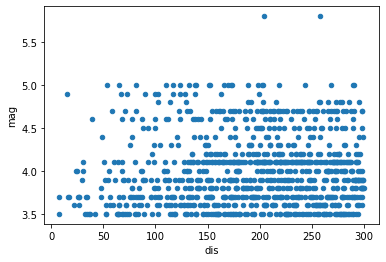

In [29]:
record.mag = record.mag.astype(float)
record.plot(x="dis",y="mag",kind="scatter")

In [ ]:
for i in range(0,len(evl)):
# for i in range(0,1):
    ev = evl[i]
    t0 = UTCDateTime(evl[i])
    print("Read event {}".format(evl[i]))
    dfinfo = eqcat[eqcat['utctime'] == UTCDateTime(evl[i])].reset_index(drop=True)
    sacl = glob("../sac_data/*{}*/*".format(evl[i]))
    stal = list(set([a.split("/")[-1].split(".")[0] for a in sacl]))
    fs,nf = [],[]
    for sta in stal:
        try:
            inv = read_inventory(os.path.join(respf,"VN.{}.xml".format(sta)))
    #         print("Found station {}".format(sta))
            fs.append(sta)
        except:
            print("Station {} not found".format(sta))
            nf.append(sta)
            pass
    sacpr = [a for a in [a for a in sacl if a.split("/")[-1].split(".")[0] in fs] if "HHN" in a]
    sacpr = [a.replace("HHN","HH*") for a in sacpr]
    # for sacfile in sacpr:
    for file in sacpr:
        print(ev,UTCDateTime(t0))
        print("Read station {} - event {}".format(sta,ev))
        time = t0
        julday = time.julday
        hhmm = time.strftime(format="%H%M")
        year = time.year
        sta = file.split("/")[-1].split(".")[0]
        inv = read_inventory(os.path.join(respf,"VN.{}.xml".format(sta)))
        for chan in inv[0][0]:
            chan.start_date = UTCDateTime(2000,1,1)
            chan.end_date = UTCDateTime(2025,1,1)
        try:

            st = obspy.read(file)
            sr = 100
            trz = st.select(component="Z")[0].interpolate(sampling_rate=sr)
            tre = st.select(component="E")[0].interpolate(sampling_rate=sr)
            trn = st.select(component="N")[0].interpolate(sampling_rate=sr)
            pre_filt = (0.005, 0.006, 30.0, 35.0)
            stla = "{:.3f}".format(inv[0][0].latitude)
            stlo = "{:.3f}".format(inv[0][0].longitude)
            stel = "{:.3f}".format(inv[0][0].elevation)
            evla = "{:.3f}".format(dfinfo.Lat[0])
            evlo = "{:.3f}".format(dfinfo.Lon[0])
            evdp = "{:.3f}".format(dfinfo.Depth[0])
            mag = "{:.1f}".format(dfinfo.Ml[0])
            dis = distcal(float(stla),float(stlo),float(evla),float(evlo))
            t0 = UTCDateTime(evl[i])
            ml = mag
            if dis < 500:
                for tr in [trz,tre,trn]:
                    tr.detrend("demean")
                    tr = correct_baseline(tr)
                    tr.stats.channel = tr.stats.channel.replace("HH ","HH")
                    tr.remove_response(inventory=inv, pre_filt=pre_filt, output="VEL",
                           water_level=60)

                    tr.trim(t0,t0+180)
                    tr.stats.sac["stla"] = float(stla)
                    tr.stats.sac["stlo"] = float(stlo)
                    tr.stats.sac["stel"] = float(stel)
                    tr.stats.sac["mag"] = float(mag)
                    tr.stats.sac["o"] = 0
                    tr.stats.sac['evla'] = float(evla)
                    tr.stats.sac['evlo'] = float(evlo)
                    tr.stats.sac['evdp'] = float(evdp)
                    tr.stats.sac['kcmpnm'] = tr.stats.sac['kcmpnm'].replace("HH ","HH")
                    chan = tr.stats.channel
                    network = "VN"
                    pathvel = os.path.join("vel",ev)
                    if not os.path.exists(pathvel):
                        os.makedirs(pathvel)
                    filevel = os.path.join(pathvel,"{}.{}.{}.{}.VEL".format(network,sta,ev,chan))
                    tr.write(filevel,format="SAC")

                    path = os.path.join("MW",ev)
                    if not os.path.exists(path):
                        os.makedirs(path)
                    filepath = os.path.join(path,"{}.{}.{}.{}.{}.{}.sac".format(network,sta,chan,year,julday,hhmm))
                    tr.write(filepath)
        except:
            print("error")
#             raise

Read event 20080302182645
Station HN1B not found
20080302182645 2008-03-02T18:26:45.000000Z
Read station BGVB - event 20080302182645
20080302182645 2008-03-02T18:26:45.000000Z
Read station MCVB - event 20080302182645
20080302182645 2008-03-02T18:26:45.000000Z
Read station THVB - event 20080302182645
20080302182645 2008-03-02T18:26:45.000000Z
Read station BCVB - event 20080302182645
20080302182645 2008-03-02T18:26:45.000000Z
Read station SLVB - event 20080302182645
20080302182645 2008-03-02T18:26:45.000000Z
Read station CBVB - event 20080302182645
20080302182645 2008-03-02T18:26:45.000000Z
Read station DBVB - event 20080302182645
20080302182645 2008-03-02T18:26:45.000000Z
Read station BGVB - event 20080302182645
20080302182645 2008-03-02T18:26:45.000000Z
Read station LSVB - event 20080302182645
20080302182645 2008-03-02T18:26:45.000000Z
Read station TTVB - event 20080302182645
20080302182645 2008-03-02T18:26:45.000000Z
Read station HBVB - event 20080302182645
20080302182645 2008-03-02T1

20081223012038 2008-12-23T01:20:38.000000Z
Read station MCVB - event 20081223012038
Read event 20081229194950
Station AGVB not found
Station BVVB not found
Station BDVB not found
Station NTVB not found
20081229194950 2008-12-29T19:49:50.000000Z
Read station MCVB - event 20081229194950
20081229194950 2008-12-29T19:49:50.000000Z
Read station TIYB - event 20081229194950
20081229194950 2008-12-29T19:49:50.000000Z
Read station THVB - event 20081229194950
20081229194950 2008-12-29T19:49:50.000000Z
Read station DBVB - event 20081229194950
20081229194950 2008-12-29T19:49:50.000000Z
Read station HBVB - event 20081229194950
20081229194950 2008-12-29T19:49:50.000000Z
Read station DHVB - event 20081229194950
20081229194950 2008-12-29T19:49:50.000000Z
Read station VIVB - event 20081229194950
20081229194950 2008-12-29T19:49:50.000000Z
Read station LSVB - event 20081229194950
20081229194950 2008-12-29T19:49:50.000000Z
Read station VTVB - event 20081229194950
20081229194950 2008-12-29T19:49:50.000000Z

20090427221808 2009-04-27T22:18:08.000000Z
Read station SLVB - event 20090427221808
20090427221808 2009-04-27T22:18:08.000000Z
Read station HUVB - event 20090427221808
20090427221808 2009-04-27T22:18:08.000000Z
Read station TGVB - event 20090427221808
20090427221808 2009-04-27T22:18:08.000000Z
Read station HBVB - event 20090427221808
20090427221808 2009-04-27T22:18:08.000000Z
Read station PLVB - event 20090427221808
20090427221808 2009-04-27T22:18:08.000000Z
Read station LSVB - event 20090427221808
20090427221808 2009-04-27T22:18:08.000000Z
Read station CBVB - event 20090427221808
20090427221808 2009-04-27T22:18:08.000000Z
Read station VTVB - event 20090427221808
20090427221808 2009-04-27T22:18:08.000000Z
Read station THVB - event 20090427221808
20090427221808 2009-04-27T22:18:08.000000Z
Read station TIYB - event 20090427221808
20090427221808 2009-04-27T22:18:08.000000Z
Read station TTVB - event 20090427221808
20090427221808 2009-04-27T22:18:08.000000Z
Read station VIVB - event 2009042

20091014015836 2009-10-14T01:58:36.000000Z
Read station VTVB - event 20091014015836
20091014015836 2009-10-14T01:58:36.000000Z
Read station CBVB - event 20091014015836
20091014015836 2009-10-14T01:58:36.000000Z
Read station HBVB - event 20091014015836
20091014015836 2009-10-14T01:58:36.000000Z
Read station PLVB - event 20091014015836
20091014015836 2009-10-14T01:58:36.000000Z
Read station LSVB - event 20091014015836
20091014015836 2009-10-14T01:58:36.000000Z
Read station MCVB - event 20091014015836
20091014015836 2009-10-14T01:58:36.000000Z
Read station SLVB - event 20091014015836
20091014015836 2009-10-14T01:58:36.000000Z
Read station TTVB - event 20091014015836
20091014015836 2009-10-14T01:58:36.000000Z
Read station TGVB - event 20091014015836
20091014015836 2009-10-14T01:58:36.000000Z
Read station VIVB - event 20091014015836
20091014015836 2009-10-14T01:58:36.000000Z
Read station THVB - event 20091014015836
20091014015836 2009-10-14T01:58:36.000000Z
Read station DBVB - event 2009101

20091213190833 2009-12-13T19:08:33.000000Z
Read station HBVB - event 20091213190833
20091213190833 2009-12-13T19:08:33.000000Z
Read station MCVB - event 20091213190833
20091213190833 2009-12-13T19:08:33.000000Z
Read station SPVB - event 20091213190833
20091213190833 2009-12-13T19:08:33.000000Z
Read station BCVB - event 20091213190833
20091213190833 2009-12-13T19:08:33.000000Z
Read station SLVB - event 20091213190833
20091213190833 2009-12-13T19:08:33.000000Z
Read station HUVB - event 20091213190833
20091213190833 2009-12-13T19:08:33.000000Z
Read station LSVB - event 20091213190833
20091213190833 2009-12-13T19:08:33.000000Z
Read station BGVB - event 20091213190833
20091213190833 2009-12-13T19:08:33.000000Z
Read station MTVB - event 20091213190833
20091213190833 2009-12-13T19:08:33.000000Z
Read station VTVB - event 20091213190833
20091213190833 2009-12-13T19:08:33.000000Z
Read station DHVB - event 20091213190833
20091213190833 2009-12-13T19:08:33.000000Z
Read station TIYB - event 2009121

20101010145100 2010-10-10T14:51:00.000000Z
Read station BCVB - event 20101010145100
20101010145100 2010-10-10T14:51:00.000000Z
Read station TIYB - event 20101010145100
20101010145100 2010-10-10T14:51:00.000000Z
Read station LSVB - event 20101010145100
20101010145100 2010-10-10T14:51:00.000000Z
Read station MTVB - event 20101010145100
Read event 20101019202149
Station AGVB not found
Station BVVB not found
Station BDVB not found
20101019202149 2010-10-19T20:21:49.000000Z
Read station BGVB - event 20101019202149
20101019202149 2010-10-19T20:21:49.000000Z
Read station TIYB - event 20101019202149
20101019202149 2010-10-19T20:21:49.000000Z
Read station MTVB - event 20101019202149
20101019202149 2010-10-19T20:21:49.000000Z
Read station BGVB - event 20101019202149
20101019202149 2010-10-19T20:21:49.000000Z
Read station LSVB - event 20101019202149
20101019202149 2010-10-19T20:21:49.000000Z
Read station TTVB - event 20101019202149
20101019202149 2010-10-19T20:21:49.000000Z
Read station CBVB - ev

20110123154619 2011-01-23T15:46:19.000000Z
Read station MTVB - event 20110123154619
20110123154619 2011-01-23T15:46:19.000000Z
Read station DBVB - event 20110123154619
Read event 20110223155316
Station AGVB not found
Station BVVB not found
Station BDVB not found
20110223155316 2011-02-23T15:53:16.000000Z
Read station BGVB - event 20110223155316
20110223155316 2011-02-23T15:53:16.000000Z
Read station THVB - event 20110223155316
20110223155316 2011-02-23T15:53:16.000000Z
Read station TGVB - event 20110223155316
20110223155316 2011-02-23T15:53:16.000000Z
Read station VIVB - event 20110223155316
20110223155316 2011-02-23T15:53:16.000000Z
Read station VTVB - event 20110223155316
20110223155316 2011-02-23T15:53:16.000000Z
Read station PLVB - event 20110223155316
20110223155316 2011-02-23T15:53:16.000000Z
Read station DBVB - event 20110223155316
20110223155316 2011-02-23T15:53:16.000000Z
Read station SPVB - event 20110223155316
20110223155316 2011-02-23T15:53:16.000000Z
Read station MTVB - ev

20121107184204 2012-11-07T18:42:04.000000Z
Read station MTVB - event 20121107184204
20121107184204 2012-11-07T18:42:04.000000Z
Read station SPVB - event 20121107184204
20121107184204 2012-11-07T18:42:04.000000Z
Read station HUVB - event 20121107184204
20121107184204 2012-11-07T18:42:04.000000Z
Read station BCVB - event 20121107184204
20121107184204 2012-11-07T18:42:04.000000Z
Read station HBVB - event 20121107184204
20121107184204 2012-11-07T18:42:04.000000Z
Read station MLAV - event 20121107184204
20121107184204 2012-11-07T18:42:04.000000Z
Read station TTVB - event 20121107184204
20121107184204 2012-11-07T18:42:04.000000Z
Read station DHVB - event 20121107184204
20121107184204 2012-11-07T18:42:04.000000Z
Read station LSVB - event 20121107184204
Read event 20130220050156
Station AGVB not found
Station BVVB not found
Station BDVB not found
Station NTVB not found
Station HDVB not found
20130220050156 2013-02-20T05:01:56.000000Z
Read station VR10 - event 20130220050156
20130220050156 2013

20140128120157 2014-01-28T12:01:57.000000Z
Read station HBVB - event 20140128120157
20140128120157 2014-01-28T12:01:57.000000Z
Read station VR09 - event 20140128120157
20140128120157 2014-01-28T12:01:57.000000Z
Read station VR08 - event 20140128120157
20140128120157 2014-01-28T12:01:57.000000Z
Read station VR05 - event 20140128120157
20140128120157 2014-01-28T12:01:57.000000Z
Read station VR19 - event 20140128120157
20140128120157 2014-01-28T12:01:57.000000Z
Read station VR04 - event 20140128120157
20140128120157 2014-01-28T12:01:57.000000Z
Read station TTVB - event 20140128120157
20140128120157 2014-01-28T12:01:57.000000Z
Read station VR21 - event 20140128120157
20140128120157 2014-01-28T12:01:57.000000Z
Read station VR14 - event 20140128120157
20140128120157 2014-01-28T12:01:57.000000Z
Read station VR13 - event 20140128120157
20140128120157 2014-01-28T12:01:57.000000Z
Read station VR01 - event 20140128120157
20140128120157 2014-01-28T12:01:57.000000Z
Read station VR25 - event 2014012

20140626124410 2014-06-26T12:44:10.000000Z
Read station PLVB - event 20140626124410
20140626124410 2014-06-26T12:44:10.000000Z
Read station TGVB - event 20140626124410
20140626124410 2014-06-26T12:44:10.000000Z
Read station VR18 - event 20140626124410
20140626124410 2014-06-26T12:44:10.000000Z
Read station VR13 - event 20140626124410
20140626124410 2014-06-26T12:44:10.000000Z
Read station VR07 - event 20140626124410
20140626124410 2014-06-26T12:44:10.000000Z
Read station VR23 - event 20140626124410
20140626124410 2014-06-26T12:44:10.000000Z
Read station VR11 - event 20140626124410
Read event 20140629045112
Station AGVB not found
Station BVVB not found
Station BDVB not found
Station NTVB not found
20140629045112 2014-06-29T04:51:12.000000Z
Read station VR17 - event 20140629045112
20140629045112 2014-06-29T04:51:12.000000Z
Read station VR15 - event 20140629045112
20140629045112 2014-06-29T04:51:12.000000Z
Read station VR18 - event 20140629045112
20140629045112 2014-06-29T04:51:12.000000Z

20140827104513 2014-08-27T10:45:13.000000Z
Read station VR25 - event 20140827104513
20140827104513 2014-08-27T10:45:13.000000Z
Read station VR09 - event 20140827104513
20140827104513 2014-08-27T10:45:13.000000Z
Read station VR13 - event 20140827104513
20140827104513 2014-08-27T10:45:13.000000Z
Read station VR14 - event 20140827104513
20140827104513 2014-08-27T10:45:13.000000Z
Read station VR15 - event 20140827104513
20140827104513 2014-08-27T10:45:13.000000Z
Read station VR10 - event 20140827104513
20140827104513 2014-08-27T10:45:13.000000Z
Read station VR01 - event 20140827104513
20140827104513 2014-08-27T10:45:13.000000Z
Read station VR07 - event 20140827104513
20140827104513 2014-08-27T10:45:13.000000Z
Read station VR02 - event 20140827104513
20140827104513 2014-08-27T10:45:13.000000Z
Read station VR12 - event 20140827104513
20140827104513 2014-08-27T10:45:13.000000Z
Read station VR05 - event 20140827104513
20140827104513 2014-08-27T10:45:13.000000Z
Read station TGVB - event 2014082

20150629011227 2015-06-29T01:12:27.000000Z
Read station VR06 - event 20150629011227
20150629011227 2015-06-29T01:12:27.000000Z
Read station VR01 - event 20150629011227
20150629011227 2015-06-29T01:12:27.000000Z
Read station VR03 - event 20150629011227
20150629011227 2015-06-29T01:12:27.000000Z
Read station VR24 - event 20150629011227
20150629011227 2015-06-29T01:12:27.000000Z
Read station VR17 - event 20150629011227
20150629011227 2015-06-29T01:12:27.000000Z
Read station VR16 - event 20150629011227
20150629011227 2015-06-29T01:12:27.000000Z
Read station VR02 - event 20150629011227
20150629011227 2015-06-29T01:12:27.000000Z
Read station VR10 - event 20150629011227
Read event 20150701200034
Station AGVB not found
Station BVVB not found
Station BDVB not found
Station NTVB not found
20150701200034 2015-07-01T20:00:34.000000Z
Read station VR17 - event 20150701200034
20150701200034 2015-07-01T20:00:34.000000Z
Read station VR24 - event 20150701200034
20150701200034 2015-07-01T20:00:34.000000Z

20150913094345 2015-09-13T09:43:45.000000Z
Read station VR06 - event 20150913094345
20150913094345 2015-09-13T09:43:45.000000Z
Read station VR14 - event 20150913094345
20150913094345 2015-09-13T09:43:45.000000Z
Read station VIVB - event 20150913094345
20150913094345 2015-09-13T09:43:45.000000Z
Read station VR10 - event 20150913094345
20150913094345 2015-09-13T09:43:45.000000Z
Read station VR17 - event 20150913094345
20150913094345 2015-09-13T09:43:45.000000Z
Read station VR16 - event 20150913094345
20150913094345 2015-09-13T09:43:45.000000Z
Read station VR21 - event 20150913094345
20150913094345 2015-09-13T09:43:45.000000Z
Read station VR23 - event 20150913094345
20150913094345 2015-09-13T09:43:45.000000Z
Read station VR15 - event 20150913094345
20150913094345 2015-09-13T09:43:45.000000Z
Read station VR01 - event 20150913094345
20150913094345 2015-09-13T09:43:45.000000Z
Read station TGVB - event 20150913094345
20150913094345 2015-09-13T09:43:45.000000Z
Read station VR05 - event 2015091

20151205215226 2015-12-05T21:52:26.000000Z
Read station VR15 - event 20151205215226
20151205215226 2015-12-05T21:52:26.000000Z
Read station TGVB - event 20151205215226
20151205215226 2015-12-05T21:52:26.000000Z
Read station VR14 - event 20151205215226
20151205215226 2015-12-05T21:52:26.000000Z
Read station VR11 - event 20151205215226
20151205215226 2015-12-05T21:52:26.000000Z
Read station VR06 - event 20151205215226
20151205215226 2015-12-05T21:52:26.000000Z
Read station VR13 - event 20151205215226
20151205215226 2015-12-05T21:52:26.000000Z
Read station VR03 - event 20151205215226
20151205215226 2015-12-05T21:52:26.000000Z
Read station VR25 - event 20151205215226
20151205215226 2015-12-05T21:52:26.000000Z
Read station VR19 - event 20151205215226
20151205215226 2015-12-05T21:52:26.000000Z
Read station VR24 - event 20151205215226
20151205215226 2015-12-05T21:52:26.000000Z
Read station VR04 - event 20151205215226
20151205215226 2015-12-05T21:52:26.000000Z
Read station VR05 - event 2015120

20160307012439 2016-03-07T01:24:39.000000Z
Read station VR10 - event 20160307012439
20160307012439 2016-03-07T01:24:39.000000Z
Read station VR02 - event 20160307012439
20160307012439 2016-03-07T01:24:39.000000Z
Read station VR12 - event 20160307012439
20160307012439 2016-03-07T01:24:39.000000Z
Read station VR09 - event 20160307012439
20160307012439 2016-03-07T01:24:39.000000Z
Read station VR18 - event 20160307012439
20160307012439 2016-03-07T01:24:39.000000Z
Read station TGVB - event 20160307012439
Read event 20160504075147
Station AGVB not found
Station BVVB not found
Station BDVB not found
Station BC2 not found
20160504075147 2016-05-04T07:51:47.000000Z
Read station VR17 - event 20160504075147
20160504075147 2016-05-04T07:51:47.000000Z
Read station VR17 - event 20160504075147
20160504075147 2016-05-04T07:51:47.000000Z
Read station VR16 - event 20160504075147
20160504075147 2016-05-04T07:51:47.000000Z
Read station VR25 - event 20160504075147
20160504075147 2016-05-04T07:51:47.000000Z


20160504221744 2016-05-04T22:17:44.000000Z
Read station VR16 - event 20160504221744
20160504221744 2016-05-04T22:17:44.000000Z
Read station VR13 - event 20160504221744
20160504221744 2016-05-04T22:17:44.000000Z
Read station VR02 - event 20160504221744
20160504221744 2016-05-04T22:17:44.000000Z
Read station HUVB - event 20160504221744
20160504221744 2016-05-04T22:17:44.000000Z
Read station VR25 - event 20160504221744
20160504221744 2016-05-04T22:17:44.000000Z
Read station VR07 - event 20160504221744
20160504221744 2016-05-04T22:17:44.000000Z
Read station VR11 - event 20160504221744
20160504221744 2016-05-04T22:17:44.000000Z
Read station VR06 - event 20160504221744
20160504221744 2016-05-04T22:17:44.000000Z
Read station VR10 - event 20160504221744
20160504221744 2016-05-04T22:17:44.000000Z
Read station VR14 - event 20160504221744
20160504221744 2016-05-04T22:17:44.000000Z
Read station VR01 - event 20160504221744
20160504221744 2016-05-04T22:17:44.000000Z
Read station VR23 - event 2016050

20161014152857 2016-10-14T15:28:57.000000Z
Read station VR10 - event 20161014152857
20161014152857 2016-10-14T15:28:57.000000Z
Read station HBVB - event 20161014152857
20161014152857 2016-10-14T15:28:57.000000Z
Read station VR22 - event 20161014152857
20161014152857 2016-10-14T15:28:57.000000Z
Read station VR25 - event 20161014152857
20161014152857 2016-10-14T15:28:57.000000Z
Read station VR02 - event 20161014152857
20161014152857 2016-10-14T15:28:57.000000Z
Read station VR17 - event 20161014152857
20161014152857 2016-10-14T15:28:57.000000Z
Read station VR04 - event 20161014152857
20161014152857 2016-10-14T15:28:57.000000Z
Read station VR15 - event 20161014152857
20161014152857 2016-10-14T15:28:57.000000Z
Read station VIVB - event 20161014152857
20161014152857 2016-10-14T15:28:57.000000Z
Read station VR08 - event 20161014152857
20161014152857 2016-10-14T15:28:57.000000Z
Read station VR13 - event 20161014152857
20161014152857 2016-10-14T15:28:57.000000Z
Read station VR24 - event 2016101

20161130141220 2016-11-30T14:12:20.000000Z
Read station VR04 - event 20161130141220
20161130141220 2016-11-30T14:12:20.000000Z
Read station VR21 - event 20161130141220
20161130141220 2016-11-30T14:12:20.000000Z
Read station TGVB - event 20161130141220
20161130141220 2016-11-30T14:12:20.000000Z
Read station HBVB - event 20161130141220
20161130141220 2016-11-30T14:12:20.000000Z
Read station VR25 - event 20161130141220
20161130141220 2016-11-30T14:12:20.000000Z
Read station VR19 - event 20161130141220
20161130141220 2016-11-30T14:12:20.000000Z
Read station VR17 - event 20161130141220
20161130141220 2016-11-30T14:12:20.000000Z
Read station VR24 - event 20161130141220
20161130141220 2016-11-30T14:12:20.000000Z
Read station VR06 - event 20161130141220
20161130141220 2016-11-30T14:12:20.000000Z
Read station VR05 - event 20161130141220
20161130141220 2016-11-30T14:12:20.000000Z
Read station VR16 - event 20161130141220
20161130141220 2016-11-30T14:12:20.000000Z
Read station VR07 - event 2016113

20170815051606 2017-08-15T05:16:06.000000Z
Read station VR25 - event 20170815051606
20170815051606 2017-08-15T05:16:06.000000Z
Read station VR02 - event 20170815051606
20170815051606 2017-08-15T05:16:06.000000Z
Read station VR18 - event 20170815051606
20170815051606 2017-08-15T05:16:06.000000Z
Read station VR10 - event 20170815051606
20170815051606 2017-08-15T05:16:06.000000Z
Read station MLAV - event 20170815051606
20170815051606 2017-08-15T05:16:06.000000Z
Read station VR16 - event 20170815051606
20170815051606 2017-08-15T05:16:06.000000Z
Read station VR05 - event 20170815051606
20170815051606 2017-08-15T05:16:06.000000Z
Read station VR04 - event 20170815051606
20170815051606 2017-08-15T05:16:06.000000Z
Read station TGVB - event 20170815051606
20170815051606 2017-08-15T05:16:06.000000Z
Read station VR24 - event 20170815051606
20170815051606 2017-08-15T05:16:06.000000Z
Read station VR21 - event 20170815051606
20170815051606 2017-08-15T05:16:06.000000Z
Read station VR03 - event 2017081

20180107201419 2018-01-07T20:14:19.000000Z
Read station VR17 - event 20180107201419
20180107201419 2018-01-07T20:14:19.000000Z
Read station VR10 - event 20180107201419
20180107201419 2018-01-07T20:14:19.000000Z
Read station VR16 - event 20180107201419
20180107201419 2018-01-07T20:14:19.000000Z
Read station VR19 - event 20180107201419
20180107201419 2018-01-07T20:14:19.000000Z
Read station VR22 - event 20180107201419
20180107201419 2018-01-07T20:14:19.000000Z
Read station VR18 - event 20180107201419
20180107201419 2018-01-07T20:14:19.000000Z
Read station VR13 - event 20180107201419
20180107201419 2018-01-07T20:14:19.000000Z
Read station VR01 - event 20180107201419
20180107201419 2018-01-07T20:14:19.000000Z
Read station PLVB - event 20180107201419
20180107201419 2018-01-07T20:14:19.000000Z
Read station VR06 - event 20180107201419
20180107201419 2018-01-07T20:14:19.000000Z
Read station VR03 - event 20180107201419
20180107201419 2018-01-07T20:14:19.000000Z
Read station VIVB - event 2018010

20180504001903 2018-05-04T00:19:03.000000Z
Read station VR19 - event 20180504001903
20180504001903 2018-05-04T00:19:03.000000Z
Read station VR25 - event 20180504001903
20180504001903 2018-05-04T00:19:03.000000Z
Read station VIVB - event 20180504001903
20180504001903 2018-05-04T00:19:03.000000Z
Read station TGVB - event 20180504001903
20180504001903 2018-05-04T00:19:03.000000Z
Read station VR09 - event 20180504001903
20180504001903 2018-05-04T00:19:03.000000Z
Read station VR03 - event 20180504001903
20180504001903 2018-05-04T00:19:03.000000Z
Read station VR01 - event 20180504001903
20180504001903 2018-05-04T00:19:03.000000Z
Read station VR17 - event 20180504001903
20180504001903 2018-05-04T00:19:03.000000Z
Read station VR13 - event 20180504001903
20180504001903 2018-05-04T00:19:03.000000Z
Read station VR23 - event 20180504001903
20180504001903 2018-05-04T00:19:03.000000Z
Read station PLVB - event 20180504001903
20180504001903 2018-05-04T00:19:03.000000Z
Read station VR18 - event 2018050

20181017230535 2018-10-17T23:05:35.000000Z
Read station VR25 - event 20181017230535
20181017230535 2018-10-17T23:05:35.000000Z
Read station VR18 - event 20181017230535
20181017230535 2018-10-17T23:05:35.000000Z
Read station TGVB - event 20181017230535
20181017230535 2018-10-17T23:05:35.000000Z
Read station VR01 - event 20181017230535
20181017230535 2018-10-17T23:05:35.000000Z
Read station VR11 - event 20181017230535
20181017230535 2018-10-17T23:05:35.000000Z
Read station VIVB - event 20181017230535
20181017230535 2018-10-17T23:05:35.000000Z
Read station VR02 - event 20181017230535
20181017230535 2018-10-17T23:05:35.000000Z
Read station VR22 - event 20181017230535
20181017230535 2018-10-17T23:05:35.000000Z
Read station VR05 - event 20181017230535
20181017230535 2018-10-17T23:05:35.000000Z
Read station VR03 - event 20181017230535
20181017230535 2018-10-17T23:05:35.000000Z
Read station HUVB - event 20181017230535
20181017230535 2018-10-17T23:05:35.000000Z
Read station VR14 - event 2018101

20190109141309 2019-01-09T14:13:09.000000Z
Read station VR17 - event 20190109141309
20190109141309 2019-01-09T14:13:09.000000Z
Read station VR22 - event 20190109141309
20190109141309 2019-01-09T14:13:09.000000Z
Read station HBVB - event 20190109141309
20190109141309 2019-01-09T14:13:09.000000Z
Read station TGVB - event 20190109141309
20190109141309 2019-01-09T14:13:09.000000Z
Read station MLAV - event 20190109141309
20190109141309 2019-01-09T14:13:09.000000Z
Read station VR04 - event 20190109141309
20190109141309 2019-01-09T14:13:09.000000Z
Read station MTVB - event 20190109141309
20190109141309 2019-01-09T14:13:09.000000Z
Read station VR09 - event 20190109141309
20190109141309 2019-01-09T14:13:09.000000Z
Read station VR01 - event 20190109141309
20190109141309 2019-01-09T14:13:09.000000Z
Read station VR02 - event 20190109141309
20190109141309 2019-01-09T14:13:09.000000Z
Read station VR15 - event 20190109141309
20190109141309 2019-01-09T14:13:09.000000Z
Read station VR11 - event 2019010

20190115182654 2019-01-15T18:26:54.000000Z
Read station VR16 - event 20190115182654
20190115182654 2019-01-15T18:26:54.000000Z
Read station VR25 - event 20190115182654
20190115182654 2019-01-15T18:26:54.000000Z
Read station VR12 - event 20190115182654
20190115182654 2019-01-15T18:26:54.000000Z
Read station VR03 - event 20190115182654
Read event 20190117053632
Station AGVB not found
Station BVVB not found
Station NTVB not found
Station BC2 not found
20190117053632 2019-01-17T05:36:32.000000Z
Read station VR25 - event 20190117053632
20190117053632 2019-01-17T05:36:32.000000Z
Read station VR01 - event 20190117053632
20190117053632 2019-01-17T05:36:32.000000Z
Read station VR22 - event 20190117053632
20190117053632 2019-01-17T05:36:32.000000Z
Read station MTVB - event 20190117053632
20190117053632 2019-01-17T05:36:32.000000Z
Read station VR09 - event 20190117053632
20190117053632 2019-01-17T05:36:32.000000Z
Read station VR10 - event 20190117053632
20190117053632 2019-01-17T05:36:32.000000Z


20190329060319 2019-03-29T06:03:19.000000Z
Read station HBVB - event 20190329060319
20190329060319 2019-03-29T06:03:19.000000Z
Read station MTVB - event 20190329060319
20190329060319 2019-03-29T06:03:19.000000Z
Read station VR01 - event 20190329060319
20190329060319 2019-03-29T06:03:19.000000Z
Read station PLVB - event 20190329060319
20190329060319 2019-03-29T06:03:19.000000Z
Read station VR10 - event 20190329060319
20190329060319 2019-03-29T06:03:19.000000Z
Read station VIVB - event 20190329060319
20190329060319 2019-03-29T06:03:19.000000Z
Read station HUVB - event 20190329060319
20190329060319 2019-03-29T06:03:19.000000Z
Read station VR09 - event 20190329060319
20190329060319 2019-03-29T06:03:19.000000Z
Read station VR22 - event 20190329060319
20190329060319 2019-03-29T06:03:19.000000Z
Read station VR18 - event 20190329060319
Read event 20190331071242
Station NTVB not found
Station AGVB not found
Station BVVB not found
Station BC2 not found
20190331071242 2019-03-31T07:12:42.000000Z


/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/network.py:254: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)
/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 4 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


Read event 20190714015136
Station AGVB not found
Station BVVB not found
Station BDVB not found
Station BC2 not found
20190714015136 2019-07-14T01:51:36.000000Z
Read station VR25 - event 20190714015136
20190714015136 2019-07-14T01:51:36.000000Z
Read station VR25 - event 20190714015136
20190714015136 2019-07-14T01:51:36.000000Z
Read station VR18 - event 20190714015136
20190714015136 2019-07-14T01:51:36.000000Z
Read station VR01 - event 20190714015136
20190714015136 2019-07-14T01:51:36.000000Z
Read station VN07 - event 20190714015136
20190714015136 2019-07-14T01:51:36.000000Z
Read station VN02 - event 20190714015136
error
20190714015136 2019-07-14T01:51:36.000000Z
Read station VR05 - event 20190714015136
20190714015136 2019-07-14T01:51:36.000000Z
Read station VR22 - event 20190714015136
20190714015136 2019-07-14T01:51:36.000000Z
Read station VN03 - event 20190714015136
20190714015136 2019-07-14T01:51:36.000000Z
Read station VN01 - event 20190714015136
20190714015136 2019-07-14T01:51:36.00

/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/network.py:254: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)
/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 4 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


20190714015136 2019-07-14T01:51:36.000000Z
Read station VN04 - event 20190714015136
20190714015136 2019-07-14T01:51:36.000000Z
Read station VR10 - event 20190714015136
20190714015136 2019-07-14T01:51:36.000000Z
Read station VR09 - event 20190714015136
20190714015136 2019-07-14T01:51:36.000000Z
Read station VN14 - event 20190714015136
error
Read event 20190714151306
Station AGVB not found
Station BVVB not found
Station BDVB not found
Station BC2 not found
20190714151306 2019-07-14T15:13:06.000000Z
Read station VR25 - event 20190714151306
20190714151306 2019-07-14T15:13:06.000000Z
Read station VN09 - event 20190714151306
20190714151306 2019-07-14T15:13:06.000000Z
Read station VR12 - event 20190714151306
20190714151306 2019-07-14T15:13:06.000000Z
Read station VR10 - event 20190714151306
error
20190714151306 2019-07-14T15:13:06.000000Z
Read station VR05 - event 20190714151306
20190714151306 2019-07-14T15:13:06.000000Z
Read station HUVB - event 20190714151306
20190714151306 2019-07-14T15:13

/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/network.py:254: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)
/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 4 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


20190714151306 2019-07-14T15:13:06.000000Z
Read station VN04 - event 20190714151306
20190714151306 2019-07-14T15:13:06.000000Z
Read station HBVB - event 20190714151306
20190714151306 2019-07-14T15:13:06.000000Z
Read station VR25 - event 20190714151306
20190714151306 2019-07-14T15:13:06.000000Z
Read station VR18 - event 20190714151306
20190714151306 2019-07-14T15:13:06.000000Z
Read station VN03 - event 20190714151306
Read event 20190720225133
Station AGVB not found
Station BVVB not found
Station BDVB not found
Station BC2 not found
20190720225133 2019-07-20T22:51:33.000000Z
Read station VR25 - event 20190720225133
20190720225133 2019-07-20T22:51:33.000000Z
Read station VR25 - event 20190720225133
20190720225133 2019-07-20T22:51:33.000000Z
Read station VIVB - event 20190720225133
20190720225133 2019-07-20T22:51:33.000000Z
Read station HUVB - event 20190720225133
20190720225133 2019-07-20T22:51:33.000000Z
Read station HBVB - event 20190720225133


/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/network.py:254: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)
/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 4 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


20190720225133 2019-07-20T22:51:33.000000Z
Read station VN04 - event 20190720225133
20190720225133 2019-07-20T22:51:33.000000Z
Read station VN09 - event 20190720225133
20190720225133 2019-07-20T22:51:33.000000Z
Read station VR09 - event 20190720225133
20190720225133 2019-07-20T22:51:33.000000Z
Read station VR22 - event 20190720225133
20190720225133 2019-07-20T22:51:33.000000Z
Read station MLAV - event 20190720225133
20190720225133 2019-07-20T22:51:33.000000Z
Read station VN07 - event 20190720225133
20190720225133 2019-07-20T22:51:33.000000Z
Read station VR18 - event 20190720225133
20190720225133 2019-07-20T22:51:33.000000Z
Read station VR10 - event 20190720225133
20190720225133 2019-07-20T22:51:33.000000Z
Read station VN15 - event 20190720225133
20190720225133 2019-07-20T22:51:33.000000Z
Read station VR01 - event 20190720225133
error
20190720225133 2019-07-20T22:51:33.000000Z
Read station VR05 - event 20190720225133
20190720225133 2019-07-20T22:51:33.000000Z
Read station VN14 - event 2

/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/network.py:254: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)
/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 4 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


20190901091146 2019-09-01T09:11:46.000000Z
Read station VN04 - event 20190901091146
20190901091146 2019-09-01T09:11:46.000000Z
Read station VR25 - event 20190901091146
20190901091146 2019-09-01T09:11:46.000000Z
Read station VR12 - event 20190901091146
20190901091146 2019-09-01T09:11:46.000000Z
Read station VN08 - event 20190901091146
20190901091146 2019-09-01T09:11:46.000000Z
Read station HBVB - event 20190901091146
20190901091146 2019-09-01T09:11:46.000000Z
Read station VR05 - event 20190901091146
20190901091146 2019-09-01T09:11:46.000000Z
Read station VN09 - event 20190901091146
20190901091146 2019-09-01T09:11:46.000000Z
Read station VR01 - event 20190901091146
20190901091146 2019-09-01T09:11:46.000000Z
Read station HUVB - event 20190901091146
20190901091146 2019-09-01T09:11:46.000000Z
Read station VN15 - event 20190901091146
20190901091146 2019-09-01T09:11:46.000000Z
Read station VN01 - event 20190901091146
20190901091146 2019-09-01T09:11:46.000000Z
Read station VR18 - event 2019090

/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/network.py:254: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)
/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 4 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


20191119004402 2019-11-19T00:44:02.000000Z
Read station VN04 - event 20191119004402
20191119004402 2019-11-19T00:44:02.000000Z
Read station VR01 - event 20191119004402
20191119004402 2019-11-19T00:44:02.000000Z
Read station VR22 - event 20191119004402
20191119004402 2019-11-19T00:44:02.000000Z
Read station VR05 - event 20191119004402
Read event 20191120083254
Station AGVB not found
Station BVVB not found
Station BDVB not found
Station NTVB not found
Station BC2 not found
20191120083254 2019-11-20T08:32:54.000000Z
Read station VR25 - event 20191120083254
20191120083254 2019-11-20T08:32:54.000000Z
Read station VR01 - event 20191120083254
20191120083254 2019-11-20T08:32:54.000000Z
Read station HBVB - event 20191120083254
20191120083254 2019-11-20T08:32:54.000000Z
Read station VN08 - event 20191120083254


/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/network.py:254: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)
/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 4 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


20191120083254 2019-11-20T08:32:54.000000Z
Read station VN04 - event 20191120083254
20191120083254 2019-11-20T08:32:54.000000Z
Read station VR25 - event 20191120083254
20191120083254 2019-11-20T08:32:54.000000Z
Read station VN01 - event 20191120083254
20191120083254 2019-11-20T08:32:54.000000Z
Read station HUVB - event 20191120083254
20191120083254 2019-11-20T08:32:54.000000Z
Read station VR09 - event 20191120083254
20191120083254 2019-11-20T08:32:54.000000Z
Read station VR03 - event 20191120083254
20191120083254 2019-11-20T08:32:54.000000Z
Read station VN14 - event 20191120083254
20191120083254 2019-11-20T08:32:54.000000Z
Read station VN15 - event 20191120083254
20191120083254 2019-11-20T08:32:54.000000Z
Read station VN03 - event 20191120083254
20191120083254 2019-11-20T08:32:54.000000Z
Read station VR22 - event 20191120083254
20191120083254 2019-11-20T08:32:54.000000Z
Read station VR05 - event 20191120083254
error
20191120083254 2019-11-20T08:32:54.000000Z
Read station VN05 - event 2

/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/network.py:254: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)
/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 4 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


20191125011820 2019-11-25T01:18:20.000000Z
Read station VN04 - event 20191125011820
Read event 20191125035653
Station AGVB not found
Station BVVB not found
Station BDVB not found
Station NTVB not found
Station BC2 not found
20191125035653 2019-11-25T03:56:53.000000Z
Read station VR25 - event 20191125035653
20191125035653 2019-11-25T03:56:53.000000Z
Read station VR05 - event 20191125035653
20191125035653 2019-11-25T03:56:53.000000Z
Read station VR01 - event 20191125035653
20191125035653 2019-11-25T03:56:53.000000Z
Read station VR09 - event 20191125035653
20191125035653 2019-11-25T03:56:53.000000Z
Read station VN08 - event 20191125035653
20191125035653 2019-11-25T03:56:53.000000Z
Read station VR03 - event 20191125035653
20191125035653 2019-11-25T03:56:53.000000Z
Read station VN01 - event 20191125035653
error
20191125035653 2019-11-25T03:56:53.000000Z
Read station VN05 - event 20191125035653
20191125035653 2019-11-25T03:56:53.000000Z
Read station VN14 - event 20191125035653
20191125035653

/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/network.py:254: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)
/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 4 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


20191125035653 2019-11-25T03:56:53.000000Z
Read station VN04 - event 20191125035653
20191125035653 2019-11-25T03:56:53.000000Z
Read station VN15 - event 20191125035653
Read event 20191127234952
Station AGVB not found
Station BVVB not found
Station BDVB not found
Station NTVB not found
Station BC2 not found
20191127234952 2019-11-27T23:49:52.000000Z
Read station VR25 - event 20191127234952
20191127234952 2019-11-27T23:49:52.000000Z
Read station VN15 - event 20191127234952
20191127234952 2019-11-27T23:49:52.000000Z
Read station VN14 - event 20191127234952
20191127234952 2019-11-27T23:49:52.000000Z
Read station VN03 - event 20191127234952


/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/network.py:254: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)
/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 4 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


20191127234952 2019-11-27T23:49:52.000000Z
Read station VN04 - event 20191127234952
20191127234952 2019-11-27T23:49:52.000000Z
Read station MLAV - event 20191127234952
20191127234952 2019-11-27T23:49:52.000000Z
Read station HBVB - event 20191127234952
20191127234952 2019-11-27T23:49:52.000000Z
Read station HUVB - event 20191127234952
20191127234952 2019-11-27T23:49:52.000000Z
Read station VR05 - event 20191127234952
20191127234952 2019-11-27T23:49:52.000000Z
Read station VR03 - event 20191127234952
20191127234952 2019-11-27T23:49:52.000000Z
Read station VR01 - event 20191127234952
20191127234952 2019-11-27T23:49:52.000000Z
Read station VN01 - event 20191127234952
20191127234952 2019-11-27T23:49:52.000000Z
Read station VN08 - event 20191127234952
20191127234952 2019-11-27T23:49:52.000000Z
Read station VR22 - event 20191127234952
20191127234952 2019-11-27T23:49:52.000000Z
Read station VR25 - event 20191127234952
error
Read event 20200122212627
Station AGVB not found
Station BVVB not foun

/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/network.py:254: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)
/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 4 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


20200122212627 2020-01-22T21:26:27.000000Z
Read station VN04 - event 20200122212627
20200122212627 2020-01-22T21:26:27.000000Z
Read station HBVB - event 20200122212627
20200122212627 2020-01-22T21:26:27.000000Z
Read station VN03 - event 20200122212627
20200122212627 2020-01-22T21:26:27.000000Z
Read station VN13 - event 20200122212627
20200122212627 2020-01-22T21:26:27.000000Z
Read station MLAV - event 20200122212627
20200122212627 2020-01-22T21:26:27.000000Z
Read station VN09 - event 20200122212627
20200122212627 2020-01-22T21:26:27.000000Z
Read station VN12 - event 20200122212627
20200122212627 2020-01-22T21:26:27.000000Z
Read station VN08 - event 20200122212627
Read event 20200228181302
Station AGVB not found
Station BVVB not found
Station BDVB not found
Station NTVB not found
Station BC2 not found
20200228181302 2020-02-28T18:13:02.000000Z
Read station VR25 - event 20200228181302
20200228181302 2020-02-28T18:13:02.000000Z
Read station VR18 - event 20200228181302
20200228181302 2020-

/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/network.py:254: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)
/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 4 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


20200228181302 2020-02-28T18:13:02.000000Z
Read station VN04 - event 20200228181302
20200228181302 2020-02-28T18:13:02.000000Z
Read station HBVB - event 20200228181302
20200228181302 2020-02-28T18:13:02.000000Z
Read station VN15 - event 20200228181302
Read event 20200616061227
Station AGVB not found
Station BVVB not found
Station BDVB not found
Station NTVB not found
Station BC2 not found
20200616061227 2020-06-16T06:12:27.000000Z
Read station VR25 - event 20200616061227
20200616061227 2020-06-16T06:12:27.000000Z
Read station VN15 - event 20200616061227
20200616061227 2020-06-16T06:12:27.000000Z
Read station VN07 - event 20200616061227
20200616061227 2020-06-16T06:12:27.000000Z
Read station VIVB - event 20200616061227
20200616061227 2020-06-16T06:12:27.000000Z
Read station HBVB - event 20200616061227
20200616061227 2020-06-16T06:12:27.000000Z
Read station VN13 - event 20200616061227
20200616061227 2020-06-16T06:12:27.000000Z
Read station VN10 - event 20200616061227
20200616061227 2020-

/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/network.py:254: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)
/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 4 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


20200616061227 2020-06-16T06:12:27.000000Z
Read station VN04 - event 20200616061227
20200616061227 2020-06-16T06:12:27.000000Z
Read station VN09 - event 20200616061227
20200616061227 2020-06-16T06:12:27.000000Z
Read station HUVB - event 20200616061227
20200616061227 2020-06-16T06:12:27.000000Z
Read station VR10 - event 20200616061227
20200616061227 2020-06-16T06:12:27.000000Z
Read station VN12 - event 20200616061227
20200616061227 2020-06-16T06:12:27.000000Z
Read station MLAV - event 20200616061227
20200616061227 2020-06-16T06:12:27.000000Z
Read station VN08 - event 20200616061227
Read event 20200626193458
Station AGVB not found
Station BVVB not found
Station BDVB not found
Station NTVB not found
Station BC2 not found
20200626193458 2020-06-26T19:34:58.000000Z
Read station VR25 - event 20200626193458
error
20200626193458 2020-06-26T19:34:58.000000Z
Read station VR18 - event 20200626193458
error
20200626193458 2020-06-26T19:34:58.000000Z
Read station MLAV - event 20200626193458
20200626

/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/network.py:254: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)
/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 4 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


20200712052156 2020-07-12T05:21:56.000000Z
Read station VN04 - event 20200712052156
20200712052156 2020-07-12T05:21:56.000000Z
Read station VR05 - event 20200712052156
20200712052156 2020-07-12T05:21:56.000000Z
Read station VR10 - event 20200712052156
20200712052156 2020-07-12T05:21:56.000000Z
Read station VR18 - event 20200712052156
20200712052156 2020-07-12T05:21:56.000000Z
Read station VN02 - event 20200712052156
20200712052156 2020-07-12T05:21:56.000000Z
Read station HUVB - event 20200712052156
20200712052156 2020-07-12T05:21:56.000000Z
Read station MLAV - event 20200712052156
20200712052156 2020-07-12T05:21:56.000000Z
Read station TGVB - event 20200712052156
20200712052156 2020-07-12T05:21:56.000000Z
Read station VN14 - event 20200712052156
20200712052156 2020-07-12T05:21:56.000000Z
Read station VN12 - event 20200712052156
20200712052156 2020-07-12T05:21:56.000000Z
Read station HBVB - event 20200712052156
20200712052156 2020-07-12T05:21:56.000000Z
Read station VIVB - event 2020071

/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/network.py:254: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)
/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 4 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


20200727051448 2020-07-27T05:14:48.000000Z
Read station VN04 - event 20200727051448
20200727051448 2020-07-27T05:14:48.000000Z
Read station VN14 - event 20200727051448
20200727051448 2020-07-27T05:14:48.000000Z
Read station VR05 - event 20200727051448
20200727051448 2020-07-27T05:14:48.000000Z
Read station HUVB - event 20200727051448
20200727051448 2020-07-27T05:14:48.000000Z
Read station VN01 - event 20200727051448
20200727051448 2020-07-27T05:14:48.000000Z
Read station VR18 - event 20200727051448
20200727051448 2020-07-27T05:14:48.000000Z
Read station VR25 - event 20200727051448
Read event 20200728012643
Station AGVB not found
Station BVVB not found
Station BDVB not found
Station NTVB not found
Station BC2 not found
20200728012643 2020-07-28T01:26:43.000000Z
Read station VR25 - event 20200728012643
20200728012643 2020-07-28T01:26:43.000000Z
Read station VN11 - event 20200728012643
20200728012643 2020-07-28T01:26:43.000000Z
Read station VR03 - event 20200728012643
20200728012643 2020-

/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/network.py:254: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)
/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 4 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


20200728012643 2020-07-28T01:26:43.000000Z
Read station VN04 - event 20200728012643
20200728012643 2020-07-28T01:26:43.000000Z
Read station TGVB - event 20200728012643
20200728012643 2020-07-28T01:26:43.000000Z
Read station VR05 - event 20200728012643
20200728012643 2020-07-28T01:26:43.000000Z
Read station MLAV - event 20200728012643
20200728012643 2020-07-28T01:26:43.000000Z
Read station VN03 - event 20200728012643
20200728012643 2020-07-28T01:26:43.000000Z
Read station HUVB - event 20200728012643
20200728012643 2020-07-28T01:26:43.000000Z
Read station VN12 - event 20200728012643
Read event 20200728132817
Station AGVB not found
Station BVVB not found
Station BDVB not found
Station BC2 not found
20200728132817 2020-07-28T13:28:17.000000Z
Read station VR25 - event 20200728132817
error
20200728132817 2020-07-28T13:28:17.000000Z
Read station VR10 - event 20200728132817
20200728132817 2020-07-28T13:28:17.000000Z
Read station VR25 - event 20200728132817
error
20200728132817 2020-07-28T13:28

/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/network.py:254: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)
/home/nghianc/bin/anaconda3/envs/eqt/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 4 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)
